Symulacje Komputerowe - Raport
==============

**Autorzy:** *Dworaczyk Marek*, *Czech Piotr* i *Oliwier Arent*

<br><br>

# Spis treści

0. Wprowadzenie
1. Zadanie nr 1: Generator ACORN (Additive Congruential Random Number) <br>
1.1. Treść zadania <br>
1.2. Rozwiązanie <br>
2. Zadanie nr 2: Generowanie rozkładu normalnego <br>
2.1. Treść zadania <br>
2.2. Rozwiązanie <br>
3. Zadanie nr 3: Metody redukcji wariancji <br>
3.1. Treść zadania <br>
3.2. Rozwiązanie <br>
4. Zadanie nr 4: Warunkowa wartość oczekiwana <br>
4.1. Treść zadania <br>
4.2. Rozwiązanie <br>
5. Zadanie nr 5: Czas ruiny <br>
5.1. Treść zadania <br>
5.2. Rozwiązanie <br>
6. Zadanie nr 6: Prawa arcusa sinusa <br>
6.1. Treść zadania <br>
6.2. Rozwiązanie <br>

<br><br>

# Wprowadzenie

Całość naszego projektu podczas rozwiązania wykorzystuje podstawowe pakiety matematyczne, które zaimportujemy:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import random
import timeit
from textwrap import wrap

from scipy.special import lambertw
from scipy.special import erfinv
from scipy.stats import poisson
from scipy.stats import norm
from scipy.stats import kstest, shapiro

Dodatkowo w ramach tworzenia i testowania raportu na własnych maszynach / maszynie Czytającego ustawimy stałe ziarno losowości, aby praca zaprezentowana była dla każdego w ten sam sposób

In [2]:
np.random.seed(2024)

Poniższa linijka wycisza wszystkie ostrzeżenia

In [3]:
warnings.filterwarnings('ignore') 

# Zadanie 1: 

## Treść zadania
Generator ACORN k-tego rzędu oparty jest na ciągach liczbowych zdefiniowanych poprzez równania rekurencyjne:

$$
X_n^0 = X_{n-1}^0, \quad n \geq 1
$$

$$
X_n^m = (X_{n-1}^m + X_n^{m-1}) \mod M, \quad m = 1, \ldots, k, \quad n \geq 1
$$

$$
Y_n^k = \frac{X_n^k}{M}, \quad n \geq 1.
$$

Jeśli ziarno (pierwszy element wektora o elementach $ X_0^m \in \{0, \ldots, M\} $), czyli $ X_0^0 \in \{1, \ldots, M - 1\} $, jest względnie pierwsze z $ M$  oraz $ M$ jest dostatecznie dużą liczbą naturalną, to generator posiada pożądane cechy, a ciąg $ Y_n^k$ dla $n \geq 1$  przypomina ciąg IID zmiennych losowych z rozkładu jednostajnego $U(0,1)$. Zaimplementuj generator jako funkcję ACORN(N, k, M, Lag) zwracającą $ N $ liczb pseudolosowych $Y_n^k$ dla $ n = 1, \ldots, N $, korzystając z algorytmu k-tego rzędu, przy pominięciu pierwszych Lag wyrazów. Przykładowymi parametrami mogą być $ M = 2^{89} - 1$ (liczba pierwsza Mersenne’a), $k = 9$, $X_0^m = 0$ dla $m \neq 0$ (mogą być dowolne), $Lag = 10^3$ (czy to na pewno OK?!). Sprawdź poprawność wyniku robiąc wykresy ciągu $ Y_n^k $, funkcji $Y_n^k \mapsto Y_{n+1}^k$ oraz histogramy. Porównaj wydajność z wbudowanym generatorem numpy. Na rysunku 1 zobaczyć możemy pomocniczą reprezentację zależności pomiędzy ciągami ciągów $X_n^k$. Szczegóły oraz odniesienia do literatury znaleźć możemy na stronie autorów algorytmu [https://acorn.wikramaratna.org/index.html](https://acorn.wikramaratna.org/index.html).



<br>

## Rozwiązanie


### Implementacja generatora ACORN i porównanie z generatorem NumPy

Generator ACORN k-tego rzędu oparty jest na ciągach liczbowych zdefiniowanych poprzez równania rekurencyjne:

$$
X^0_n = X^0_{n-1}, \quad n \geq 1
$$

$$
X^m_n = (X^{m-1}_n + X^m_{n-1}) \mod M, \quad m = 1, \ldots, k, \quad n \geq 1
$$

$$
Y^k_n = \frac{X^k_n}{M}, \quad n \geq 1
$$

Poniżej znajduje się implementacja tego algorytmu:

In [123]:
def ACORN(N, k, M, Lag, seed):
    """
    Funkcja ACORN generuje N pseudolosowych liczb z przedziału (0, 1) 
    wykorzystując algorytm bazujący na metodzie lagged Fibonacci generator (LFG).

    Parametry:
    N (int): Liczba pseudolosowych liczb do wygenerowania.
    k (int): Wymiar tablicy X.
    M (int): Modulo, które określa maksymalną wartość liczb w tablicy X.
    Lag (int): Liczba początkowych wartości do pominięcia (lag).
    seed (int): Początkowa wartość, ziarno, które musi być względnie pierwsze z M.

    Zwraca:
    list: Lista N wygenerowanych pseudolosowych liczb z przedziału (0, 1).
    """

    def gcd(a, b):
        """
        Funkcja oblicza największy wspólny dzielnik (GCD) dwóch liczb a i b 
        przy użyciu algorytmu Euklidesa.

        Parametry:
        a (int): Pierwsza liczba.
        b (int): Druga liczba.

        Zwraca:
        int: Największy wspólny dzielnik (GCD) a i b.
        """
        while b:
            a, b = b, a % b
        return a

    
    assert gcd(seed, M) == 1

    # Inicjalizacja dwuwymiarowej listy X
    X = [[0] * (k + 1) for _ in range(Lag + N + 1)]
    X[0][0] = seed

    # Generowanie wartości z pominięciem pierwszych Lag
    for n in range(1, Lag + N + 1):
        X[n][0] = X[n - 1][0]
        for m in range(1, k + 1):
            X[n][m] = (X[n - 1][m] + X[n][m - 1]) % M

    # Obliczanie wartości Y dla następnych N wartości po pominięciu Lag
    Y = [X[n + Lag][k] / M for n in range(1, N + 1)]
    
    return Y

# Parametry
N = 1000
k = 9
M = 2**89 - 1
Lag = 1000
seed = 9999999

# Funkcja do mierzenia czasu wykonania ACORN
def measure_acorn():
    ACORN(N, k, M, Lag, seed)

# Funkcja do mierzenia czasu wykonania NumPy
def measure_numpy():
    np.random.random(N)

# Mierzenie czasu wykonania ACORN
acorn_duration = timeit.timeit(measure_acorn, number=10) / 10

# Mierzenie czasu wykonania NumPy
numpy_duration = timeit.timeit(measure_numpy, number=10) / 10

# Obliczanie ilorazu czasów
time_ratio = acorn_duration / numpy_duration

# Generowanie liczb pseudolosowych dla wykresów
acorn_numbers = ACORN(N, k, M, Lag, seed)
numpy_numbers = np.random.random(N)

Czas wykonania funkcji ACORN: 0.00509361 sekundy
Czas wykonania funkcji NumPy: 0.00001357 sekundy
Stosunek czasu (ACORN/NumPy): 375.36


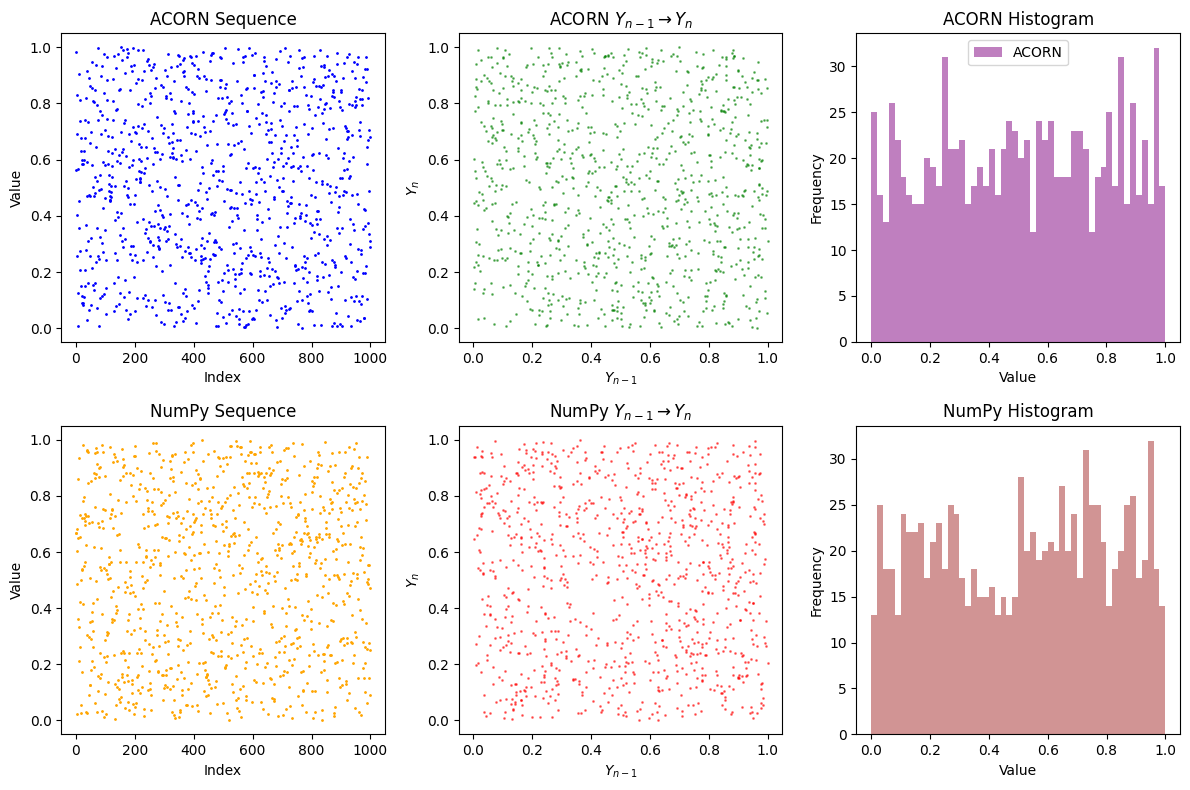

In [124]:
plt.figure(figsize=(12, 8))

# Wykresy dla ACORN
plt.subplot(231)
plt.plot(acorn_numbers, 'o',  color='blue', markersize=1)
plt.title('ACORN Sequence')
plt.xlabel('Index')
plt.ylabel('Value')


plt.subplot(232)
plt.scatter(acorn_numbers[:-1], acorn_numbers[1:], alpha=0.5, s=1, color='green')
plt.title('ACORN $Y_{n-1} \\rightarrow Y_n$')
plt.xlabel('$Y_{n-1}$')
plt.ylabel('$Y_n$')

plt.subplot(233)
plt.hist(acorn_numbers, bins=50, alpha=0.5, label='ACORN', color='purple')
plt.title('ACORN Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Wykresy dla NumPy
plt.subplot(234)
plt.plot(numpy_numbers, 'o',  color='orange', markersize=1)
plt.title('NumPy Sequence')
plt.xlabel('Index')
plt.ylabel('Value')


plt.subplot(235)
plt.scatter(numpy_numbers[:-1], numpy_numbers[1:], alpha=0.5, s=1, color='red')
plt.title('NumPy $Y_{n-1} \\rightarrow Y_n$')
plt.xlabel('$Y_{n-1}$')
plt.ylabel('$Y_n$')

plt.subplot(236)
plt.hist(numpy_numbers, bins=50, alpha=0.5, label='NumPy', color='brown')
plt.title('NumPy Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')


plt.tight_layout()
# Wyświetlanie czasów wykonania i ilorazu czasów
print(f"Czas wykonania funkcji ACORN: {acorn_duration:.8f} sekundy")
print(f"Czas wykonania funkcji NumPy: {numpy_duration:.8f} sekundy")
print(f"Stosunek czasu (ACORN/NumPy): {time_ratio:.2f}")

 Oba generatory produkują liczby losowe o dobrych właściwościach statystycznych. Na wykresach punktowych dla obu generatorów widoczne jest równomierne rozłożenie punktów, co sugeruje brak wyraźnych wzorców i niezależność generowanych wartości. Histogramy dla obu generatorów również pokazują równomierne rozłożenie wartości w przedziale od 0 do 1, z podobnymi wysokościami słupków, co potwierdza równomierność generacji liczb losowych. Jednakże, pod względem wydajności, generator NumPy jest zdecydowanie szybszy, wykonując generowanie w czasie około 375 razy krótszym niż ACORN.

Sprawdzimy teraz jak bardzo czas wykonywania się algorytmów różni się  w zależności od ilości liczb pseudolosowych do wygenerowania.

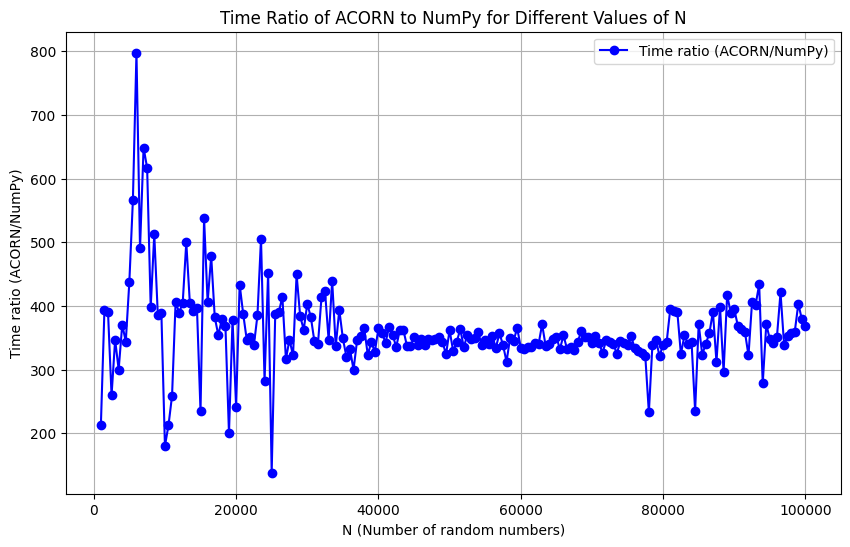

In [125]:
N_values = range(1000, 100001, 500)

# Listy do przechowywania czasów wykonania
acorn_durations = []
numpy_durations = []
time_ratios = []

# Pomiar czasu dla różnych wartości N
for N in N_values:
    # Funkcja do mierzenia czasu wykonania ACORN
    def measure_acorn():
        ACORN(N, k, M, Lag, seed)

    # Funkcja do mierzenia czasu wykonania NumPy
    def measure_numpy():
        np.random.random(N)

    # Mierzenie czasu wykonania ACORN
    acorn_duration = timeit.timeit(measure_acorn, number=10) / 10
    acorn_durations.append(acorn_duration)

    # Mierzenie czasu wykonania NumPy
    numpy_duration = timeit.timeit(measure_numpy, number=10) / 10
    numpy_durations.append(numpy_duration)

    # Obliczanie ilorazu czasów
    time_ratio = acorn_duration / numpy_duration
    time_ratios.append(time_ratio)

# Tworzenie wykresu ilorazu czasów
plt.figure(figsize=(10, 6))

plt.plot(N_values, time_ratios, 'o-', label='Time ratio (ACORN/NumPy)', color='blue')

plt.xlabel('N (Number of random numbers)')
plt.ylabel('Time ratio (ACORN/NumPy)')
plt.title('Time Ratio of ACORN to NumPy for Different Values of N')
plt.legend()
plt.grid(True)

Jak możemy zobaczyć na wykresie dla mniejszych wartości N, iloraz czasu wykonania jest znacznie wyższy i bardziej zmienny. W miarę wzrostu wartości N, stabilizuje się (na poziomie około 350) i staje się bardziej przewidywalny.Wskazuje to, że choć ACORN może być wolniejszy dla małych N, jego względna wydajność poprawia się przy większych wartościach.

### Analiza generatora ACORN względem zmiennej Lag

Dla trzech różnych wartości parametru Lag: 10,400,10000 wygenerujemy 1000 liczb pseudolosowych.

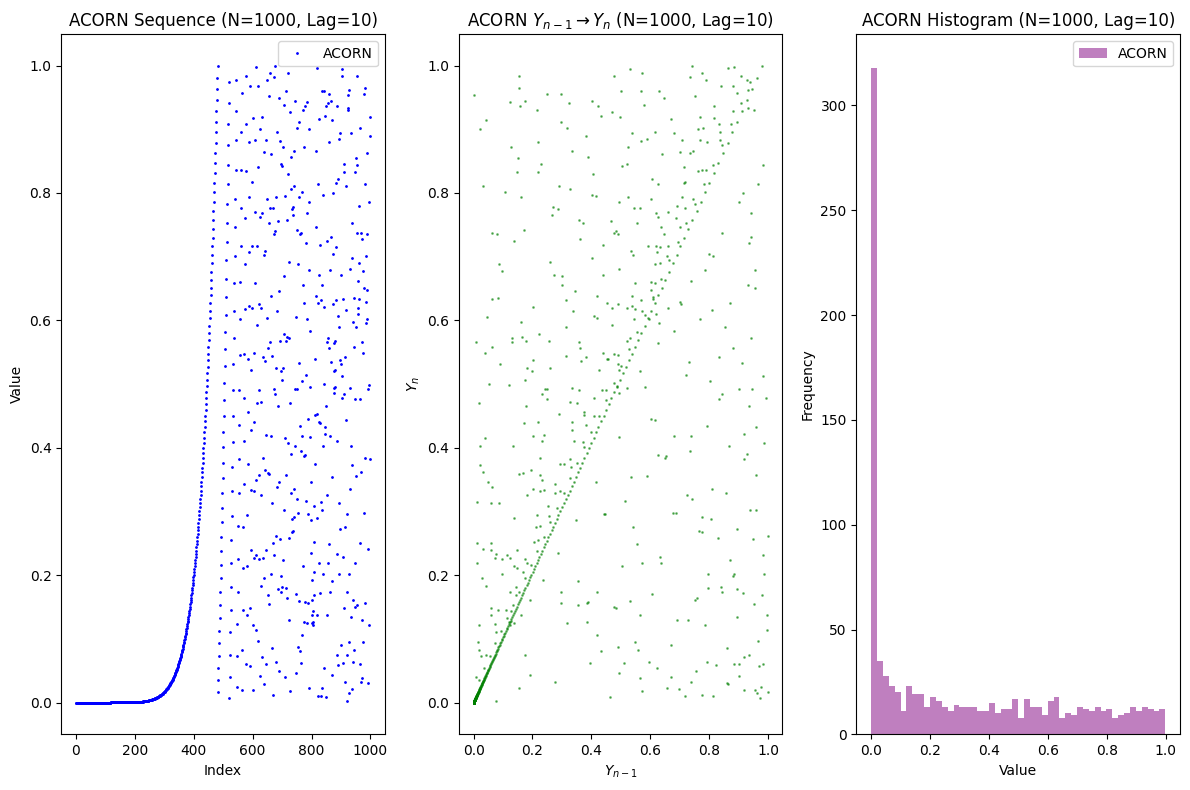

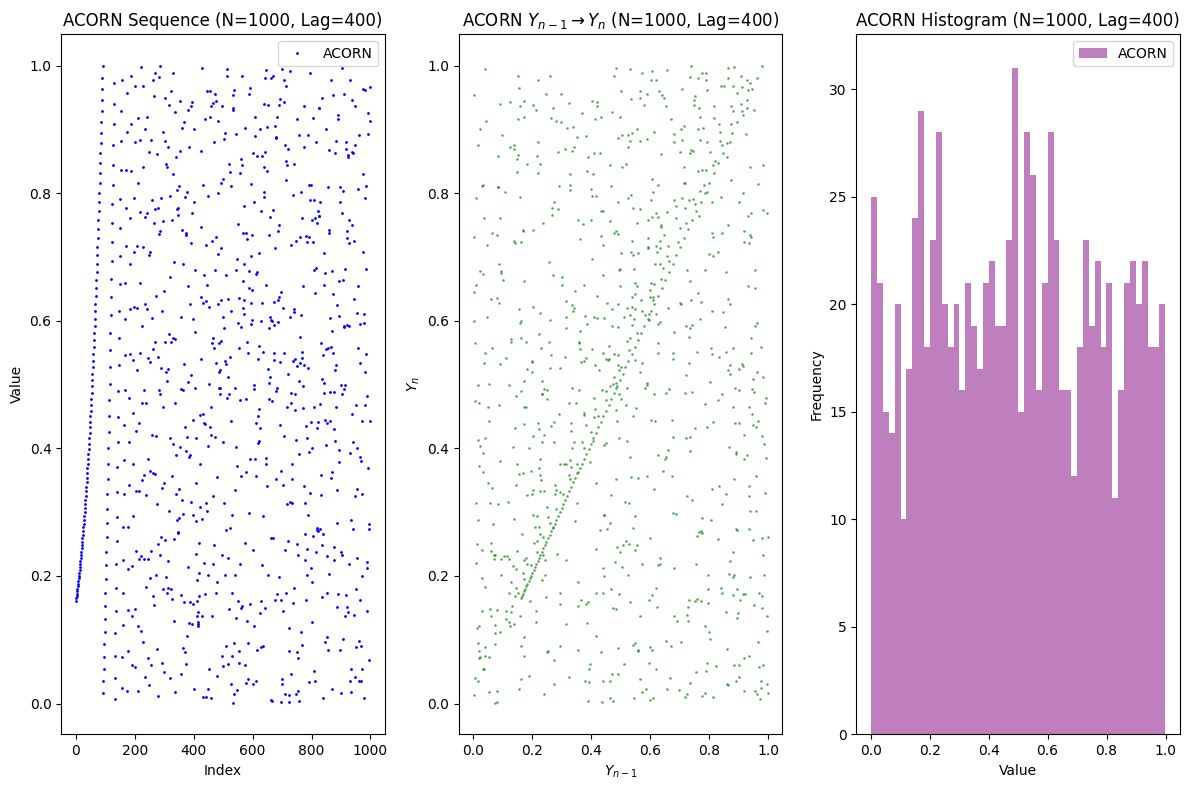

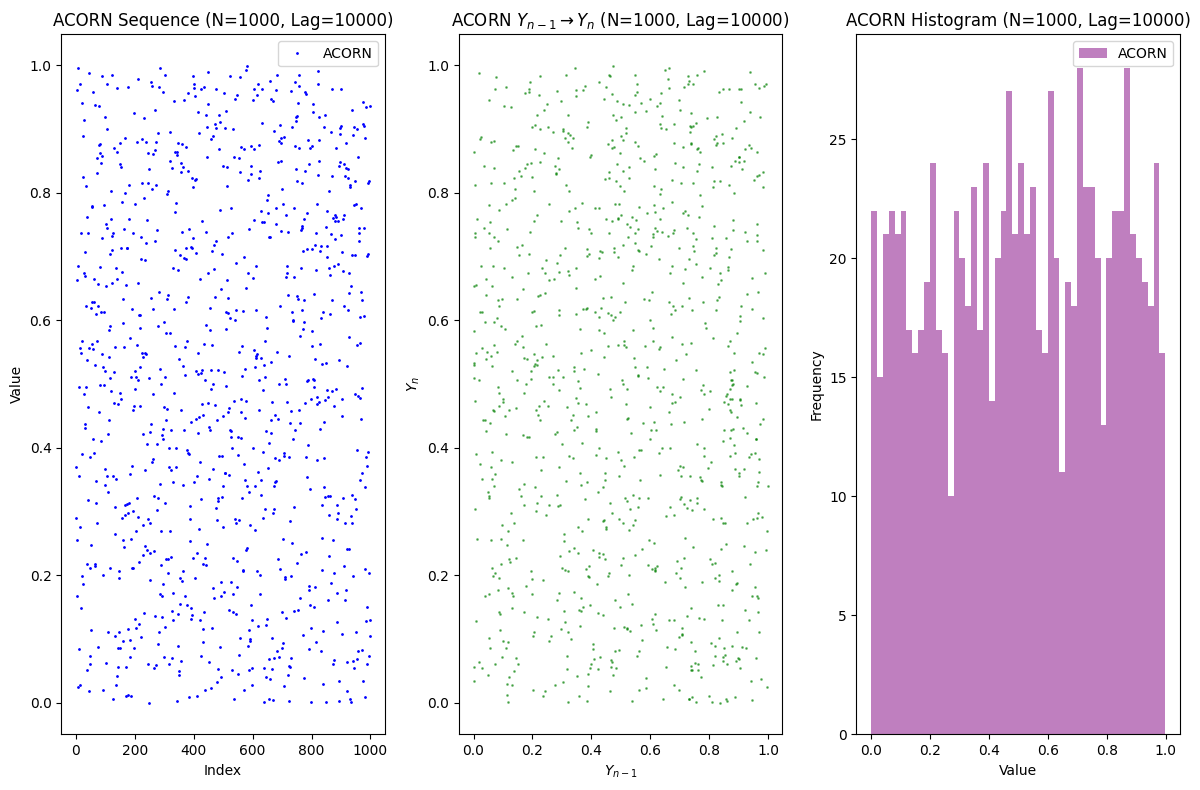

In [34]:
N= 1000
Lag_values = [10, 400, 10000]
for Lag in Lag_values:
    # Generowanie liczb pseudolosowych przy użyciu ACORN
    acorn_numbers = ACORN(N, k, M, Lag, seed)

    # Wykresy dla ACORN
    plt.figure(figsize=(12, 8))

    plt.subplot(131)
    plt.plot(acorn_numbers, 'o', label='ACORN', color='blue', markersize=1)
    plt.title(f'ACORN Sequence (N={N}, Lag={Lag})')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()

    plt.subplot(132)
    plt.scatter(acorn_numbers[:-1], acorn_numbers[1:], alpha=0.5, s=1, color='green')
    plt.title(f'ACORN $Y_{{n-1}} \\rightarrow Y_n$ (N={N}, Lag={Lag})')
    plt.xlabel('$Y_{n-1}$')
    plt.ylabel('$Y_n$')

    plt.subplot(133)
    plt.hist(acorn_numbers, bins=50, alpha=0.5, label='ACORN', color='purple')
    plt.title(f'ACORN Histogram (N={N}, Lag={Lag})')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()

Z analizy wykresów dla różnych wartości parametru Lag wynika, że zwiększanie jego wartości w funkcji ACORN znacząco poprawia losowość generowanych liczb pseudolosowych. Przy niskich wartościach Lag, sekwencje liczb wykazują silną autokorelację, co jest widoczne jako skoncentrowane skupiska wartości oraz liniowe zależności na wykresach  $Y_{n-1} \rightarrow Y_n$. W miarę wzrostu Lag, zarówno sekwencje, jak i rozkład liczb stają się bardziej równomierne, a wykresy rozproszenia tracą liniową zależność, co wskazuje na poprawę jakości losowości. Histogramy dla wyższych wartości Lag pokazują bardziej płaski i równomierny rozkład, a nie jak w przypadku histogramu dla Lag = 10,który pokazuje nierównomierny rozkład liczb, z dużą koncentracją wartości blisko 0, co dodatkowo potwierdza, że wyższe wartości Lag prowadzą do lepszej losowości w generowanych liczbach.Wprowadzają większy "odstęp czasowy" między kolejnymi wartościami wykorzystywanymi do generowania nowych liczb pseudolosowych. Dzięki temu każdy nowy numer jest obliczany na podstawie wartości oddalonych od siebie w sekwencji, co zmniejsza korelację między kolejnymi wartościami. W praktyce oznacza to, że każda nowa liczba jest mniej zależna od bezpośrednio poprzednich liczb, co prowadzi do bardziej losowego i mniej przewidywalnego rozkładu.

### Analiza generatora ACORN względem zmiennej seed

Dla trzech różnych wartości parametru seed: 167,99999,123456789 wygenerujemy 1000 liczb pseudolosowych.

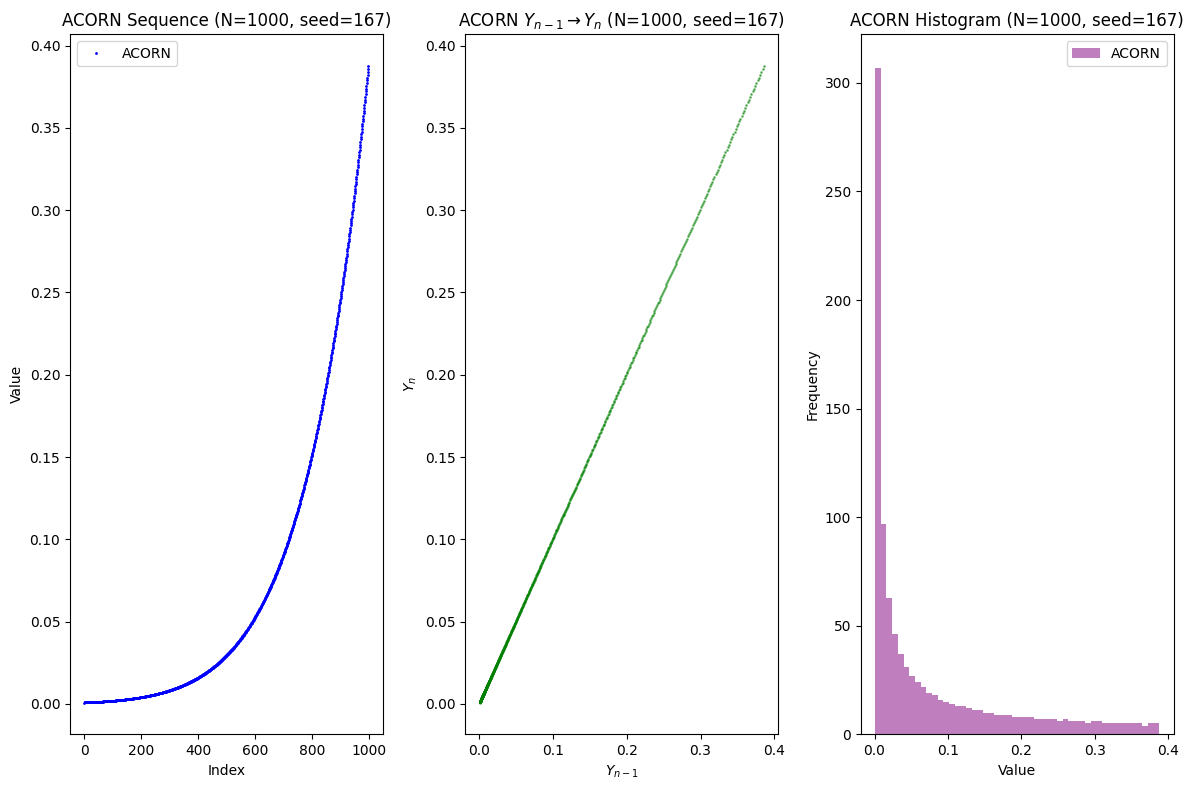

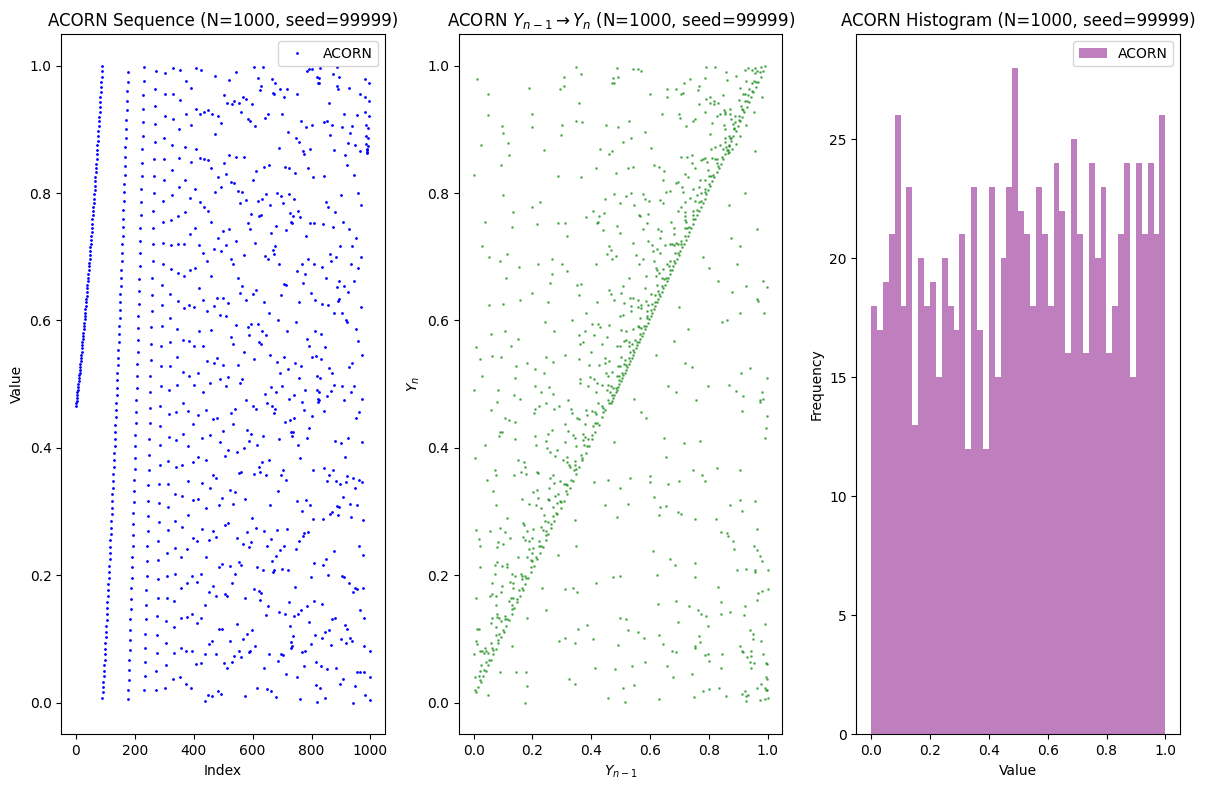

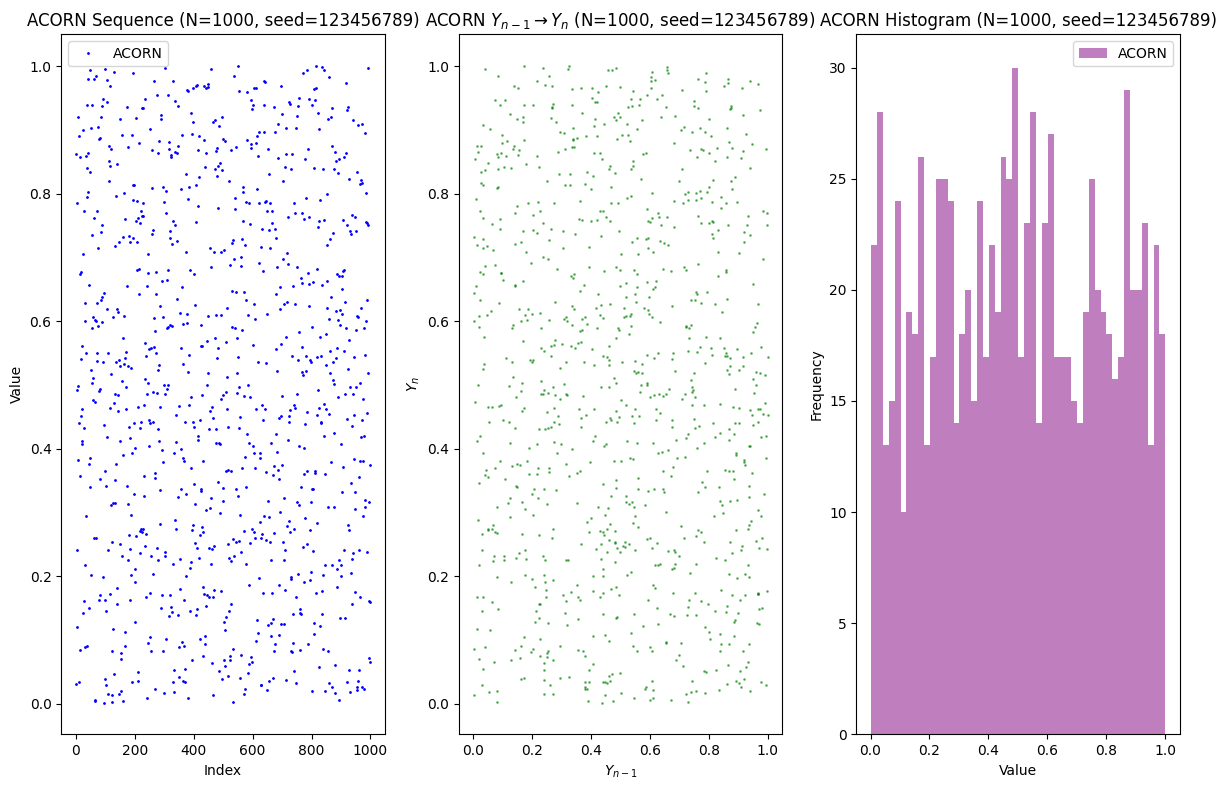

In [39]:
seed_values = [167,99999 ,123456789 ]

for seed in seed_values:
    # Generowanie liczb pseudolosowych przy użyciu ACORN
    acorn_numbers = ACORN(N, k, M, Lag, seed)

    # Wykresy dla ACORN
    plt.figure(figsize=(12, 8))

    plt.subplot(131)
    plt.plot(acorn_numbers, 'o', label='ACORN', color='blue', markersize=1)
    plt.title(f'ACORN Sequence (N={N}, seed={seed})')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()

    plt.subplot(132)
    plt.scatter(acorn_numbers[:-1], acorn_numbers[1:], alpha=0.5, s=1, color='green')
    plt.title(f'ACORN $Y_{{n-1}} \\rightarrow Y_n$ (N={N}, seed={seed})')
    plt.xlabel('$Y_{n-1}$')
    plt.ylabel('$Y_n$')

    plt.subplot(133)
    plt.hist(acorn_numbers, bins=50, alpha=0.5, label='ACORN', color='purple')
    plt.title(f'ACORN Histogram (N={N}, seed={seed})')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()

Analiza wykresów pokazuje, że wartość parametru seed ma znaczący wpływ na jakość generowanych liczb pseudolosowych w funkcji ACORN. Dla niskich wartości seed, takich jak 167, widoczny jest nieliniowy wzorzec w sekwencji liczb, gdzie wartości początkowo są bliskie zeru, a następnie rosną wykładniczo. Na drugim wykresie  zauważalna jest silna liniowa zależność między kolejnymi wartościami, co wskazuje na wysoką autokorelację. Histogram dla tej wartości pokazuje, że wartości są mocno skoncentrowane w dolnej części przedziału (0, 0.4), co również wskazuje na nierównomierny rozkład.Dla seed = 999999, sekwencja liczb jest bardziej równomiernie rozłożona, choć nadal można zauważyć pewne liniowe skupiska punktów na wykresie. Wykres $Y_{n-1} \rightarrow Y_n$ jest bardziej rozproszony, ale wciąż widoczna jest pewna zależność liniowa, choć mniej wyraźna niż w przypadku seed = 167. Histogram jest bardziej równomierny. Dla seed = 123456789, sekwencja liczb jest najbardziej równomiernie rozłożona z wszystkich trzech przykładów, bez widocznych regularnych wzorców. Wykres $Y_{n-1} \rightarrow Y_n$ jest najbardziej rozproszony i mniej przewidywalny, co jest oznaką lepszej losowości. Podsumowując małe wartości seed mogą nie wprowadzać wystarczającej ilości "szumu" w początkowych etapach generowania liczb, co prowadzi do przewidywalnych i powtarzalnych wzorców. W przypadku wyższych wartości seed, początkowe warunki są bardziej zróżnicowane, co wprowadza więcej losowości od samego początku, prowadząc do bardziej równomiernego i rozproszonego rozkładu wartości. 


# Zadanie 2: 

## Treść zadania

Na listach zadań poznaliśmy kilka metod generowania rozkładu normalnego - nie są to jedyne znane i powszechnie używane metody. W pierwszym kroku sprawdź dotychczas zaimplementowane algorytmy, czy działają poprawnie.

W drugim kroku, zaimplementuj dwie dodatkowe metody generowania rozkładu normalnego:

- metodę "tuzina" przykładowa implementacja w linku poniżej

- metodę zigguratu
  [https://en.wikipedia.org/wiki/Ziggurat_algorithm](https://en.wikipedia.org/wiki/Ziggurat_algorithm)
  używając rozkładu wykładniczego. Przetestuj ile razy musimy obliczać funkcję wykładniczą dla różnych wyborów schodków.

Finalnie, porównaj efektywność generowania rozkładu normalnego za pomocą samodzielnie zaimplementowanych metod. Rozważ zarówno czas wykonania algorytmu, jak i dokładność symulacji.

Sprawdź też:
[https://stat.gov.pl/files/gfx/portalinformacyjny/pl/defaultaktualnosci/5982/7/56/1/ws_07_2019__02_porownanie_generatorow_liczb_pseudolosowych__piotr_sulewski.pdf](https://stat.gov.pl/files/gfx/portalinformacyjny/pl/defaultaktualnosci/5982/7/56/1/ws_07_2019__02_porownanie_generatorow_liczb_pseudolosowych__piotr_sulewski.pdf)


<br>

## Rozwiązanie


###  &#x2160;    Implementacja metod generowania rozkładu normalnego poznanych na zajęciach.

#### Metoda stosunku jednostajnych

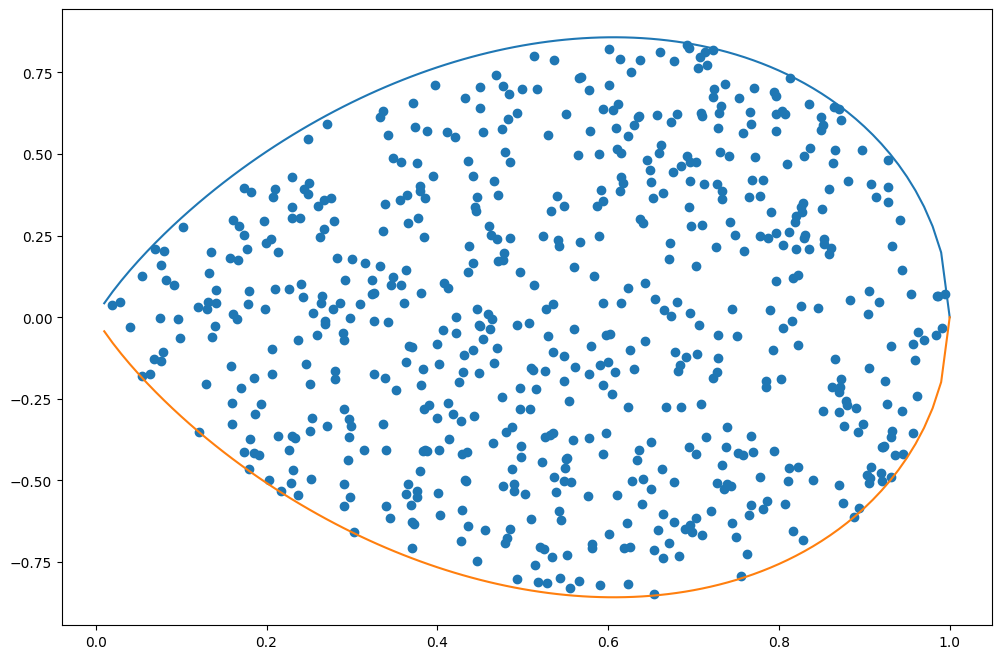

In [51]:
def normal_gen(n):
    # Inicjalizacja pustych list do przechowywania wygenerowanych próbek
    xs = []
    ys = []

    # Generowanie próbek
    for i in range(n):
        # Generowanie dwóch zmiennych losowych o równomiernym rozkładzie w zakresie [0, 1] i [-1, 1]
        X = np.random.uniform(0, 1)
        Y = np.random.uniform(-1, 1)
        
        # Obliczanie kwadratowej wartości i sprawdzanie warunków
        if X > 0:  # Unikamy dzielenia przez zero
            log_term = np.log(1 / X)
            sqrt_term = np.sqrt(log_term)
            if Y <= 2 * X * sqrt_term:
                if Y >= -2 * X * sqrt_term: 
                    xs.append(X)
                    ys.append(Y)
    
    # Zwracanie wygenerowanych próbek
    return xs, ys

# Generowanie 1000 próbek
zs = normal_gen(1000)
plt.figure(figsize=(12,8))
# Rysowanie wykresu rozproszenia wygenerowanych próbek
plt.scatter(zs[0], zs[1])

# Definiowanie zakresu wartości x dla funkcji ograniczających
x = np.linspace(0.01, 1, 100)  # Zaczynamy od 0.01, aby uniknąć log(0)
y1 = 2 * x * np.sqrt(np.log(1 / x))
y2 = -2 * x * np.sqrt(np.log(1 / x))

# Rysowanie funkcji ograniczających na wykresie
plt.plot(x, y1);
plt.plot(x, y2);

#### Metoda odwrotnej dystrybuanty

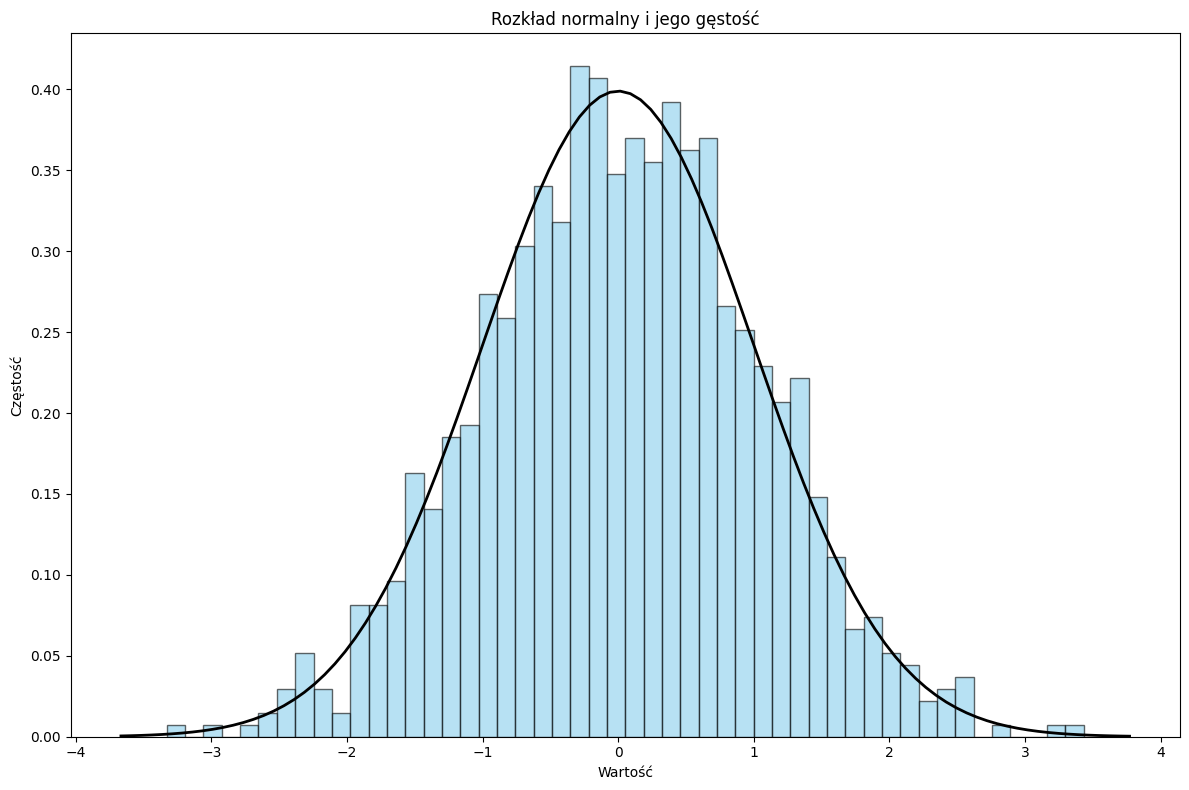

In [72]:
#Parametry
mu_normal = 0
sigma_normal = 1

def inverse_transform_normal(mu, sigma, size=1):
    """
    Generowanie zmiennych losowych o rozkładzie normalnym N(µ,σ^2)
    metodą odwrotnej dystrybuanty.
    
    Parametry:
        mu (float): Średnia rozkładu normalnego.
        sigma (float): Odchylenie standardowe rozkładu normalnego.
        size (int): Liczba zmiennych losowych do wygenerowania.
        
    Zwraca:
        numpy.ndarray: Tablica zmiennych losowych o rozkładzie normalnym.
    """
    u = np.random.uniform(0, 1, size)
    return mu + sigma*np.sqrt(2)*erfinv(2*u-1)

normal_values = inverse_transform_normal(mu_normal, sigma_normal, size=1000)

# Rysowanie histogramu
plt.figure(figsize=(12, 8))
count, bins, ignored = plt.hist(normal_values, bins=50, color='skyblue', edgecolor='black', density=True, alpha=0.6)

# Dodanie krzywej gęstości prawdopodobieństwa
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_normal, sigma_normal)
plt.plot(x, p, 'k', linewidth=2)

title = 'Rozkład normalny i jego gęstość'
plt.title(title)
plt.xlabel('Wartość')
plt.ylabel('Częstość')
plt.tight_layout()

#### Metoda akceptacji-odrzucenia

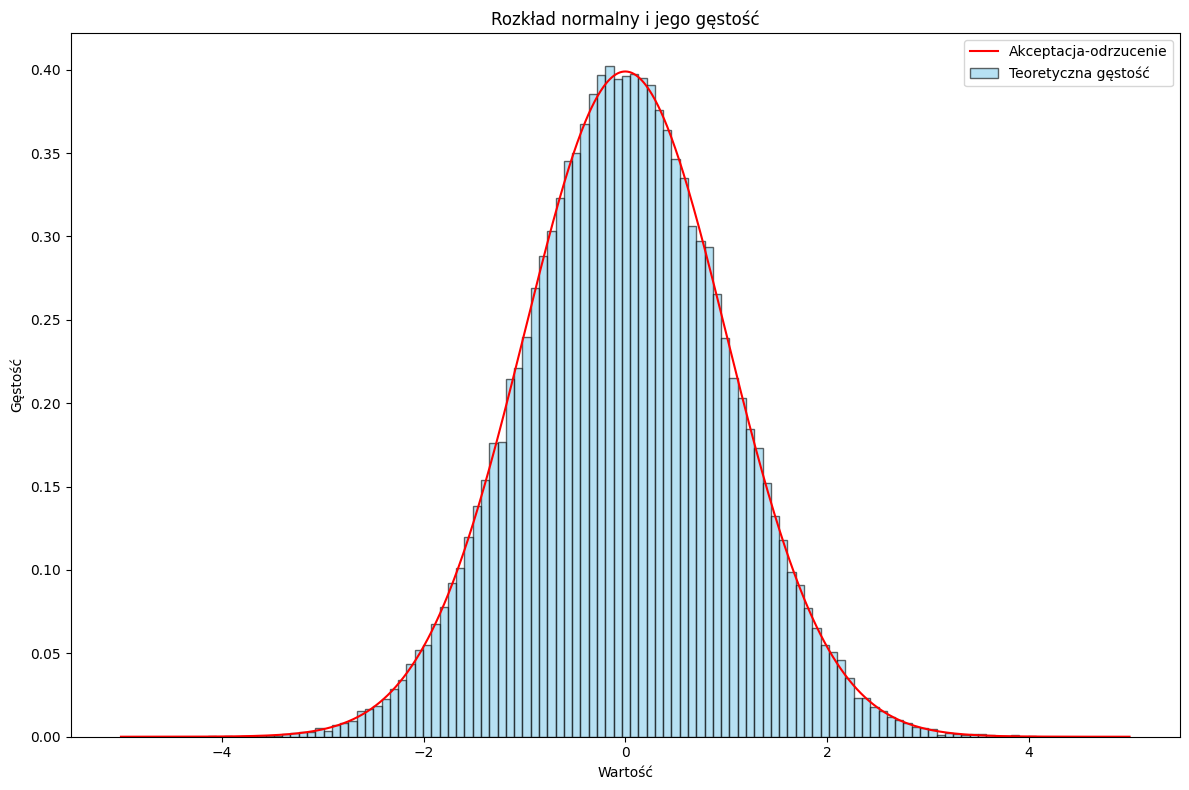

In [69]:
def exp_distribution(lambd=1):
    """
    Generuje próbkę z rozkładu wykładniczego o parametrze lambda.

    Parametry:
        lambd (float): Parametr lambda rozkładu wykładniczego.

    Zwraca:
        float: Wygenerowana próbka z rozkładu wykładniczego.
    """
    u = np.random.uniform(0, 1)
    return -1 / lambd * np.log(u)

def half_normal_distribution(c, lambd=1):
    """
    Generuje próbkę z połowicznego rozkładu normalnego metodą akceptacji-odrzucenia.

    Parametry:
        c (float): Stała akceptacji-odrzucenia.
        lambd (float): Parametr lambda rozkładu wykładniczego.

    Zwraca:
        float: Wygenerowana próbka z połowicznego rozkładu normalnego.
    """
    i = 0
    while i == 0:
        y = exp_distribution(lambd)
        u = np.random.uniform(0, 1)
        # Sprawdzenie warunku akceptacji próbki
        if u <= abs(1 / (2 * np.pi) * np.exp(-y**2 / 2)) / (c * lambd * np.exp(-lambd * y)):
            i += 1
            return y

def normal_distribution(c, n=1000, lambd=1):
    """
    Generuje próbki z rozkładu normalnego metodą akceptacji-odrzucenia.

    Parametry:
        c (float): Stała akceptacji-odrzucenia.
        n (int): Liczba próbek do wygenerowania.
        lambd (float): Parametr lambda rozkładu wykładniczego.

    Zwraca:
        list: Lista wygenerowanych próbek z rozkładu normalnego.
    """
    arr = []
    i = 0
    counter = 0
    while i < n:
        counter += 1
        u = random.random()
        if u <= 0.5:
            # Generowanie próbki dla wartości dodatnich
            while u != 1:
                y = exp_distribution(lambd)
                a = np.random.uniform(0, 1)
                if a <= (1 / (2 * np.pi) * np.exp(-(y ** 2) / 2)) / (c * 0.5 * lambd * np.exp(-lambd * y)):
                    u = 1
                    i += 1
                    arr.append(y)
        else:
            # Generowanie próbki dla wartości ujemnych
            while u != 1:
                y = -exp_distribution(lambd)
                p = abs(y)
                a = np.random.uniform(0, 1)
                if a <= (1 / (2 * np.pi) * np.exp(-(p ** 2) / 2)) / (c * 0.5 * lambd * np.exp(-lambd * p)):
                    i += 1
                    u = 1
                    arr.append(y)

    return arr

def normal_dist_density(x):
    """
    Oblicza gęstość rozkładu normalnego dla zadanej wartości x.

    Parametry:
        x (numpy.ndarray): Wartości, dla których obliczana jest gęstość rozkładu normalnego.

    Zwraca:
        numpy.ndarray: Gęstość rozkładu normalnego dla zadanych wartości x.
    """
    return 1 / np.sqrt(2 * np.pi) * np.exp(-x**2 / 2)

# Generowanie 100000 próbek z rozkładu normalnego
arr = normal_distribution(1, 100000)

# Definiowanie zakresu wartości x do wykresu
x = np.linspace(-5, 5, 1000)
y = normal_dist_density(x)

# Rysowanie histogramu wygenerowanych próbek oraz teoretycznej gęstości rozkładu normalnego
plt.figure(figsize=(12, 8))
plt.hist(arr, density=True, bins=100, color='skyblue', edgecolor='black', alpha=0.6)
plt.plot(x, y, color='r')
plt.legend(['Akceptacja-odrzucenie', 'Teoretyczna gęstość'], loc="upper right")
plt.xlabel('Wartość')
plt.ylabel('Gęstość')
plt.title('Rozkład normalny i jego gęstość')
plt.tight_layout()

#### Metoda biegunowa generowania rozkładu normalnego w wersji Boxa–Mullera oraz Marsaglii

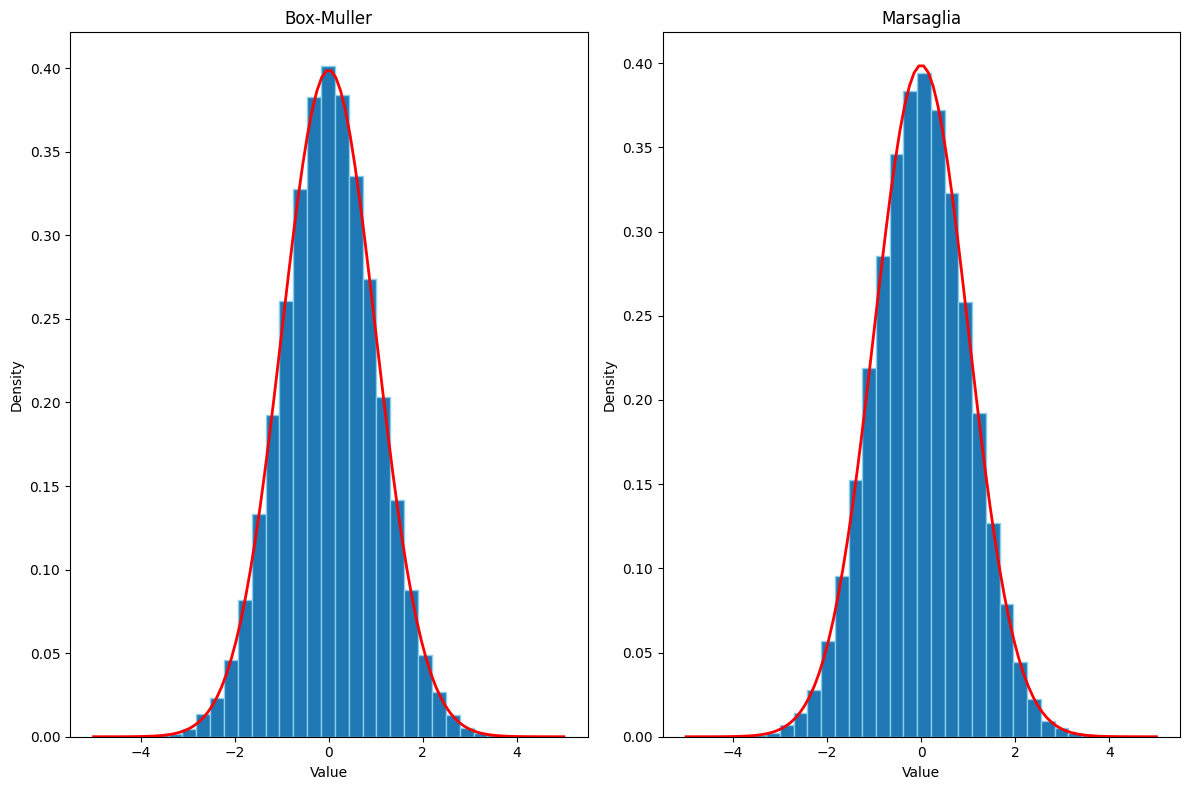

In [68]:
def normal_distribution_BM(samples, loc=0, scale=1):
    """
    Generuje próbki z rozkładu normalnego za pomocą transformacji Boxa-Mullera.

    Parametry:
        samples (int): Liczba próbek do wygenerowania.
        loc (float): Średnia rozkładu normalnego.
        scale (float): Odchylenie standardowe rozkładu normalnego.

    Zwraca:
        tuple: Dwie tablice numpy zawierające próbki z rozkładu normalnego.
    """
    # Generowanie standardowych próbek normalnych za pomocą transformacji Boxa-Mullera
    U1 = np.random.uniform(0, 1, samples)
    U2 = np.random.uniform(0, 1, samples)
    Z1 = np.sqrt(-2 * np.log(U1)) * np.cos(2 * np.pi * U2)
    Z2 = np.sqrt(-2 * np.log(U1)) * np.sin(2 * np.pi * U2)
    
    # Zastosowanie transformacji lokalizacji i skali
    normal_samples = loc + scale * Z1, loc + scale * Z2
    
    return normal_samples

def normal_distribution_M(samples, loc=0, scale=1):
    """
    Generuje próbki z rozkładu normalnego za pomocą algorytmu Marsaglia-Bray.

    Parametry:
        samples (int): Liczba próbek do wygenerowania.
        loc (float): Średnia rozkładu normalnego.
        scale (float): Odchylenie standardowe rozkładu normalnego.

    Zwraca:
        tuple: Dwie tablice numpy zawierające próbki z rozkładu normalnego.
    """
    Z1_list = []
    Z2_list = []
    while len(Z1_list) < samples:
        U1 = np.random.uniform(-1, 1)
        U2 = np.random.uniform(-1, 1)
        R2 = U1**2 + U2**2
        if R2 < 1:
            Z1 = U1 * np.sqrt(-2 * np.log(R2) / R2)
            Z2 = U2 * np.sqrt(-2 * np.log(R2) / R2)
            Z1_list.append(Z1)
            Z2_list.append(Z2)
    Z1_array = np.array(Z1_list)
    Z2_array = np.array(Z2_list)
    
    # Zastosowanie transformacji lokalizacji i skali
    normal_samples = loc + scale * Z1_array, loc + scale * Z2_array
    
    return normal_samples

# Generowanie próbek normalnych
num_samples = 100000
start_time = time.time()
normal_samples_BM = normal_distribution_BM(num_samples)[0]
end_time = time.time()
BMTime = end_time-start_time

num_samples = 100000
start_time = time.time()
normal_samples_M = normal_distribution_M(num_samples)[0]
end_time = time.time()
MTime = end_time-start_time

# Tworzenie histogramu
plt.figure(figsize=(12, 8))

# Histogram Box-Muller
plt.subplot(1, 2, 1)
plt.hist(normal_samples_BM, bins=30, density=True, edgecolor='skyblue')
x = np.linspace(-5, 5, 100)
plt.plot(x, norm.pdf(x, loc=0, scale=1), 'r-', label='N(0,1)', linewidth=2)
plt.title('Box-Muller')
plt.xlabel('Value')
plt.ylabel('Density')

# Histogram Marsaglia
plt.subplot(1, 2, 2)
plt.hist(normal_samples_M, bins=30, density=True, edgecolor='skyblue')
x = np.linspace(-5, 5, 100)
plt.plot(x, norm.pdf(x, loc=0, scale=1), 'r-', label='N(0,1)', linewidth=2)
plt.title('Marsaglia')
plt.xlabel('Value')
plt.ylabel('Density')
plt.tight_layout()

### &#x2160;&#x2160; Implementacja metody "tuzina" i "zigguratu" oraz porównanie ich ze sobą.

#### Metoda tuzina

Niech $U_1, U_2, \ldots, U_{12}$ będą liczbami pseudolosowymi $U(0,1)$. Metoda tuzina generująca liczbę pseudolosową $Y$ z $N(m, s)$ jest opisana za pomocą algorytmu:

1. $S = \sum_{i=1}^{12} U_i$
2. $X = S - 6$
3. $Y = sX + m$
\
\
Poniżej znajduje się implementacja tego algorytmu:

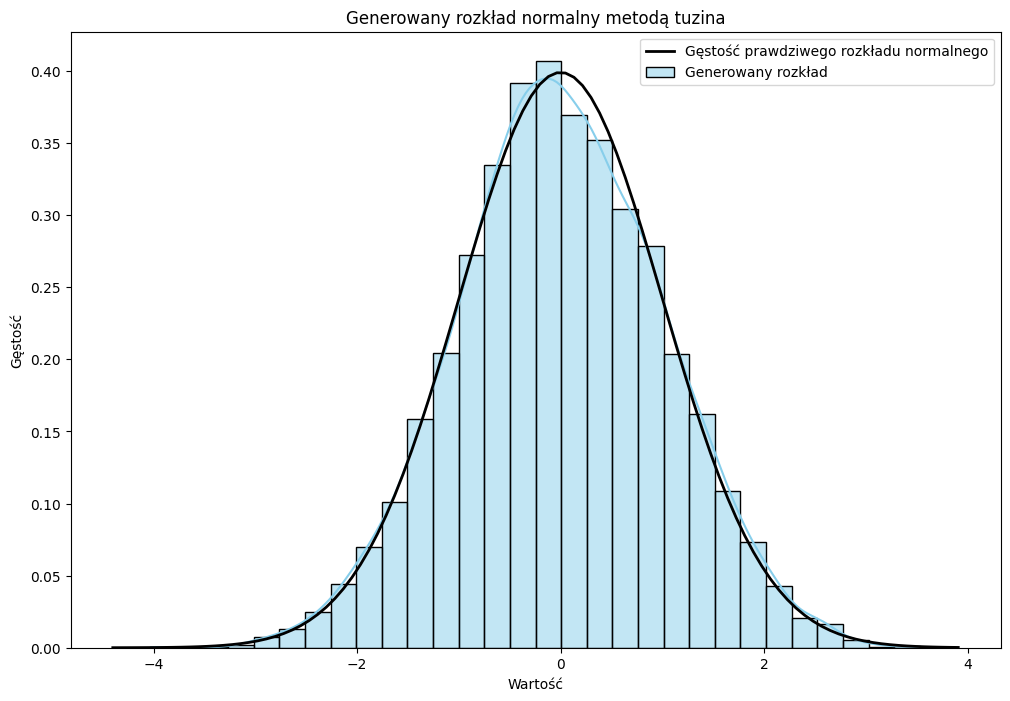

In [67]:
def tuzin_method(n, m, s):
    """
    Generuje pojedynczą liczbę z rozkładu normalnego N(m, s) metodą tuzina.

    Parametry:
    n (int): Liczba liczb pseudolosowych U(0,1).
    m (float): Średnia rozkładu normalnego.
    s (float): Odchylenie standardowe rozkładu normalnego.

    Zwraca:
    float: Liczba z rozkładu normalnego N(m, s).
    """
    U = np.random.uniform(0, 1, n)  # Generowanie n liczb pseudolosowych U(0,1)
    S = np.sum(U)  # Obliczanie sumy S
    X = S - (n / 2)  # Korygowanie sumy S
    Y = s * X + m  # Przekształcenie X w wartość z rozkładu normalnego
    return Y

# Parametry
n = 12  # Liczba liczb pseudolosowych
m = 0  # Średnia rozkładu normalnego
s = 1  # Odchylenie standardowe rozkładu normalnego
num_samples = 10000  # Liczba próbek do wygenerowania

# Generowanie liczb z rozkładu normalnego metodą tuzina
samples = [tuzin_method(n, m, s) for _ in range(num_samples)]

# Rysowanie histogramu i gęstości
plt.figure(figsize=(12, 8))
sns.histplot(samples, kde=True, stat='density', bins=30, color='skyblue', label='Generowany rozkład')

# Rysowanie gęstości prawdziwego rozkładu normalnego
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, m, s)
plt.plot(x, p, 'k', linewidth=2, label='Gęstość prawdziwego rozkładu normalnego')

plt.title('Generowany rozkład normalny metodą tuzina')
plt.xlabel('Wartość')
plt.ylabel('Gęstość')
plt.legend();

#### Metoda zigguratu
Pełny algorytm zigguratu do generowania rozkładu normalnego używając rozkładu wykładniczego jest następujący:

1. Wybierz losową warstwę $ 0 \leq i < n .$
2. Niech $ x = U_0 x_i .$
3. Jeśli $ x < x_{i+1} $, zwróć $ x .$
4. Jeśli  $i = 0$ , wygeneruj punkt z ogona przy użyciu algorytmu zapasowego:
    - Niech $ x = -\ln(U_1) / x_1$.
    - Niech $ y = -\ln(U_2) $.
    - Jeśli $ 2y > x^2 $, zwróć $ x + x_1 $.
    - W przeciwnym razie wróć do kroku 4.
5. Niech $ y = y_i + U_1 (y_{i+1} - y_i)$.
6. Oblicz $ f(x) $. Jeśli $y < f(x) $, zwróć $ x $.
7. W przeciwnym razie wybierz nowe liczby losowe i wróć do kroku 1.

Poniżej znajduje się implementacja tego algorytmu:

Rozmiar kroku: 128, Wywołania funkcji wykładniczej: 6420
Rozmiar kroku: 256, Wywołania funkcji wykładniczej: 8231
Rozmiar kroku: 512, Wywołania funkcji wykładniczej: 9127
Rozmiar kroku: 1024, Wywołania funkcji wykładniczej: 9562


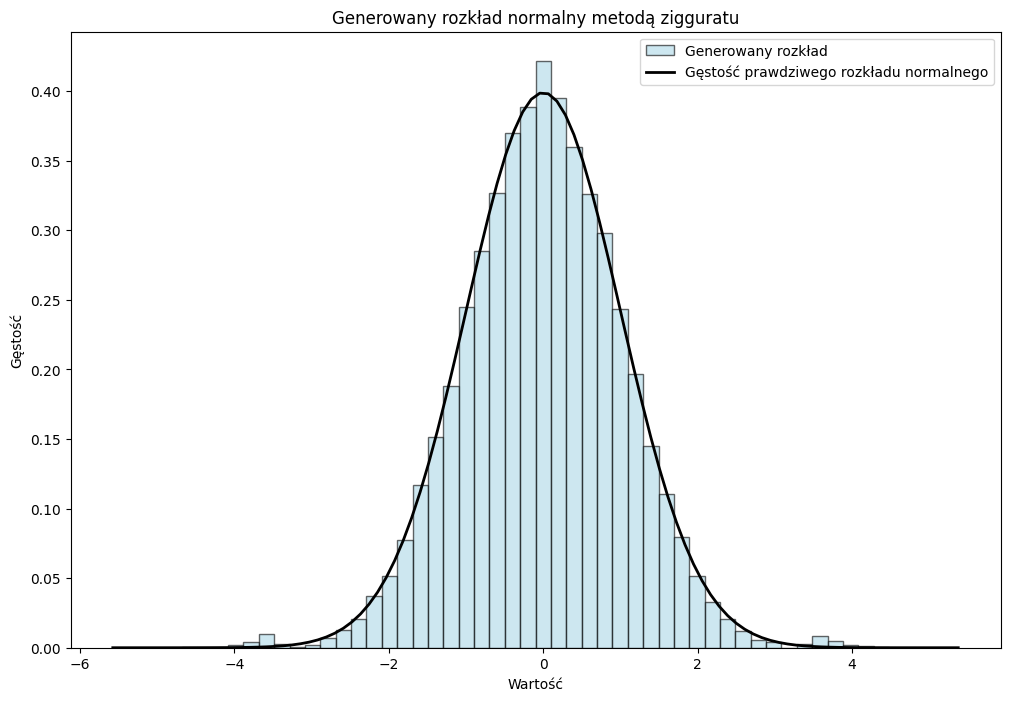

In [73]:
# Stałe
r = 3.442619855899
v = 9.91256303526217e-3

def initialize_tables(n):
    """
    Inicjalizuje tablice x i y dla algorytmu zigguratu.

    Argumenty:
    n -- liczba kroków

    Zwraca:
    x -- tablica wartości x
    y -- tablica wartości y
    """
    x = np.zeros(n + 1)
    y = np.zeros(n)

    x[0] = r
    for i in range(1, n):
        try:
            value = v / x[i - 1] + np.exp(-0.5 * x[i - 1]**2)
            x[i] = np.sqrt(-2 * np.log(value))
        except (ValueError, RuntimeWarning):
            x[i] = x[i - 1]  # Ignoruj błąd i przypisz poprzednią wartość

    x[n] = 0.0
    y = np.exp(-0.5 * x**2)
    return x, y

def ziggurat_normal(x, y):
    """
    Generuje próbkę z rozkładu normalnego za pomocą algorytmu zigguratu.

    Argumenty:
    x -- tablica wartości x
    y -- tablica wartości y

    Zwraca:
    Próbkę z rozkładu normalnego
    """
    global exp_call_count
    n = len(x) - 1

    while True:
        u = np.random.uniform(-1, 1)
        i = np.random.randint(0, n)
        x_i = x[i]
        x_ip1 = x[i + 1]

        if abs(u) < y[i]:
            return u * x_ip1

        if i == 0:
            while True:
                x_ = -np.log(np.random.uniform(0, 1)) / r
                y_ = -np.log(np.random.uniform(0, 1))
                exp_call_count += 2
                if 2 * y_ > x_**2:
                    if u < 0:
                        return -r - x_
                    else:
                        return r + x_

        x_ = x_ip1 + np.random.uniform(0, 1) * (x_i - x_ip1)
        exp_call_count += 1
        if np.exp(-0.5 * x_**2) < np.random.uniform(0, 1) * y[i]:
            continue

        return u * x_

def test_ziggurat(step_sizes):
    """
    Testuje algorytm zigguratu i liczy wywołania funkcji wykładniczej dla różnych rozmiarów kroków.

    Argumenty:
    step_sizes -- lista różnych rozmiarów kroków do przetestowania

    Zwraca:
    exp_calls -- lista liczby wywołań funkcji wykładniczej dla każdego rozmiaru kroku
    """
    global exp_call_count
    exp_calls = []
    for steps in step_sizes:
        exp_call_count = 0
        x, y = initialize_tables(steps)
        np.random.seed(0)
        for _ in range(10000):
            _ = ziggurat_normal(x, y)
        exp_calls.append(exp_call_count)
    return exp_calls

def plot_distribution():
    """
    Generuje i wyświetla histogram próbek z rozkładu normalnego uzyskanych metodą zigguratu.
    """
    x, y = initialize_tables(256)  # Użyj domyślnej wielkości kroku do rysowania
    samples = [ziggurat_normal(x, y) for _ in range(100000)]
    
    plt.figure(figsize=(12, 8))  # Dostosuj rozmiar wykresu tutaj
    plt.hist(samples, bins=50, density=True, alpha=0.6, color='lightblue', edgecolor='black', label="Generowany rozkład")

    # Rysowanie funkcji gęstości normalnej
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, 0, 1)
    plt.plot(x, p, 'k', linewidth=2, label='Gęstość prawdziwego rozkładu normalnego')
    
    plt.title("Generowany rozkład normalny metodą zigguratu")
    plt.xlabel("Wartość")
    plt.ylabel("Gęstość")
    plt.legend(loc='upper right')
    plt.show()

# Definiowanie różnych rozmiarów kroków do przetestowania
step_sizes = [128, 256, 512, 1024]

# Liczenie wywołań funkcji wykładniczej dla różnych rozmiarów kroków
exp_calls = test_ziggurat(step_sizes)
for steps, calls in zip(step_sizes, exp_calls):
    print(f"Rozmiar kroku: {steps}, Wywołania funkcji wykładniczej: {calls}")

# Rysowanie rozkładu
plot_distribution()

Jak możemy zauważyć wraz ze zwiększaniem rozmiaru kroku w algorytmie zigguratu, liczba wywołań funkcji wykładniczej również rośnie, co wskazuje na większe obciążenie obliczeniowe. Optymalny wybór rozmiaru kroku zależy od kompromisu między precyzją wyników a wydajnością obliczeniową.

 Sprawdzimy teraz czas wykonywania obu metod oraz wykersy ich rozkładów

Dla n = 1000:
Metoda tuzina - czas wykonania: 0.018988 sekund
Metoda zigguratu - czas wykonania: 0.020986 sekund
Dla n = 10000:
Metoda tuzina - czas wykonania: 0.157905 sekund
Metoda zigguratu - czas wykonania: 0.234856 sekund
Dla n = 100000:
Metoda tuzina - czas wykonania: 1.810884 sekund
Metoda zigguratu - czas wykonania: 2.165814 sekund
Dla n = 1000000:
Metoda tuzina - czas wykonania: 17.832701 sekund
Metoda zigguratu - czas wykonania: 23.537302 sekund


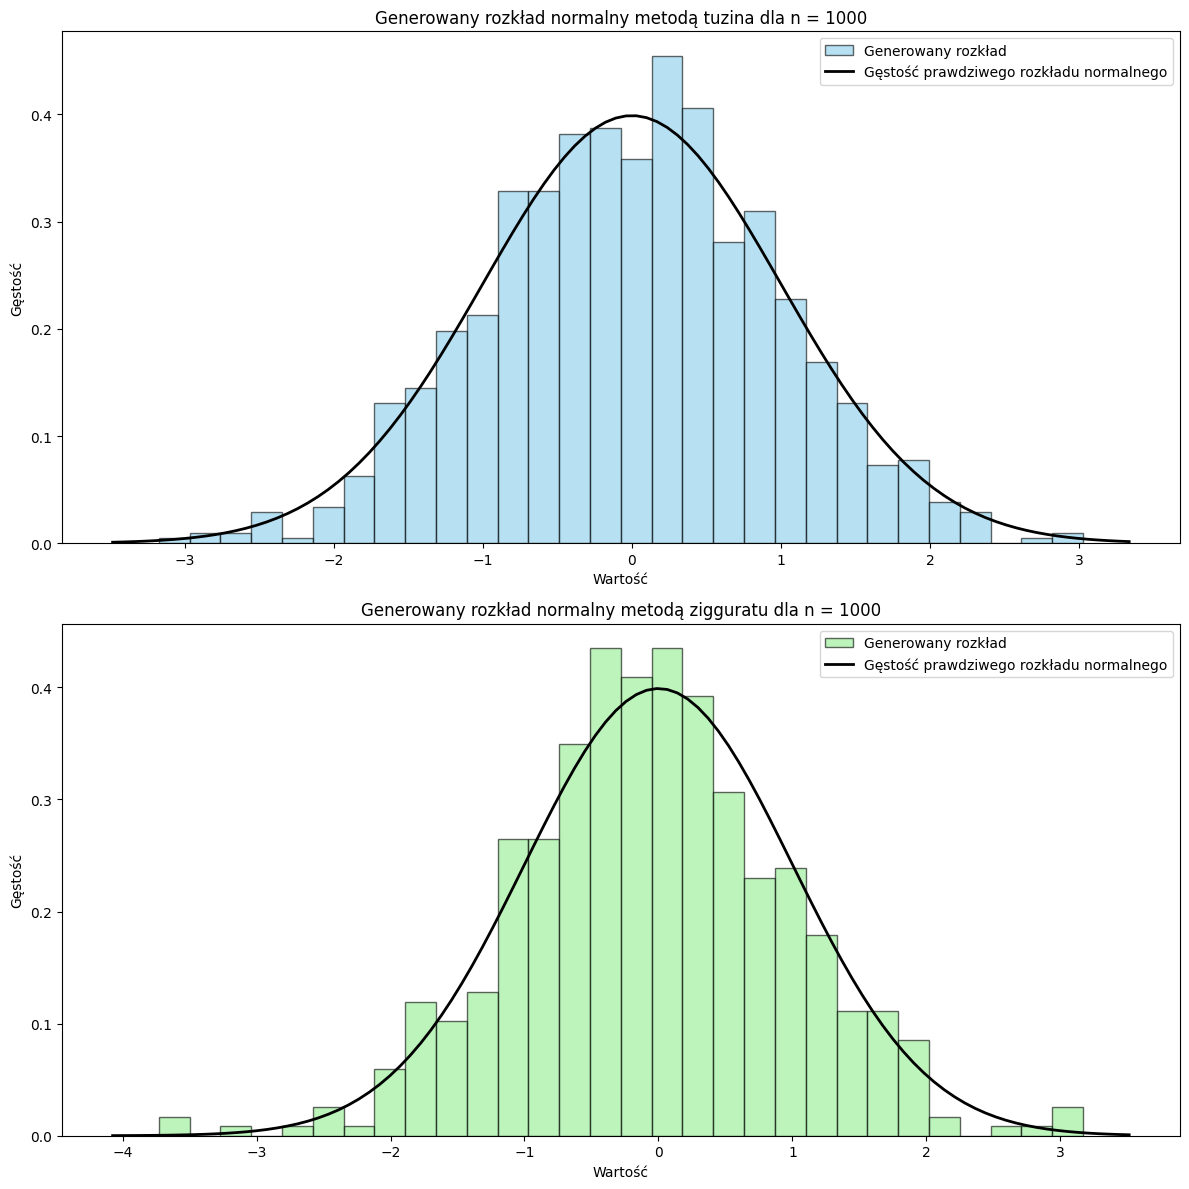

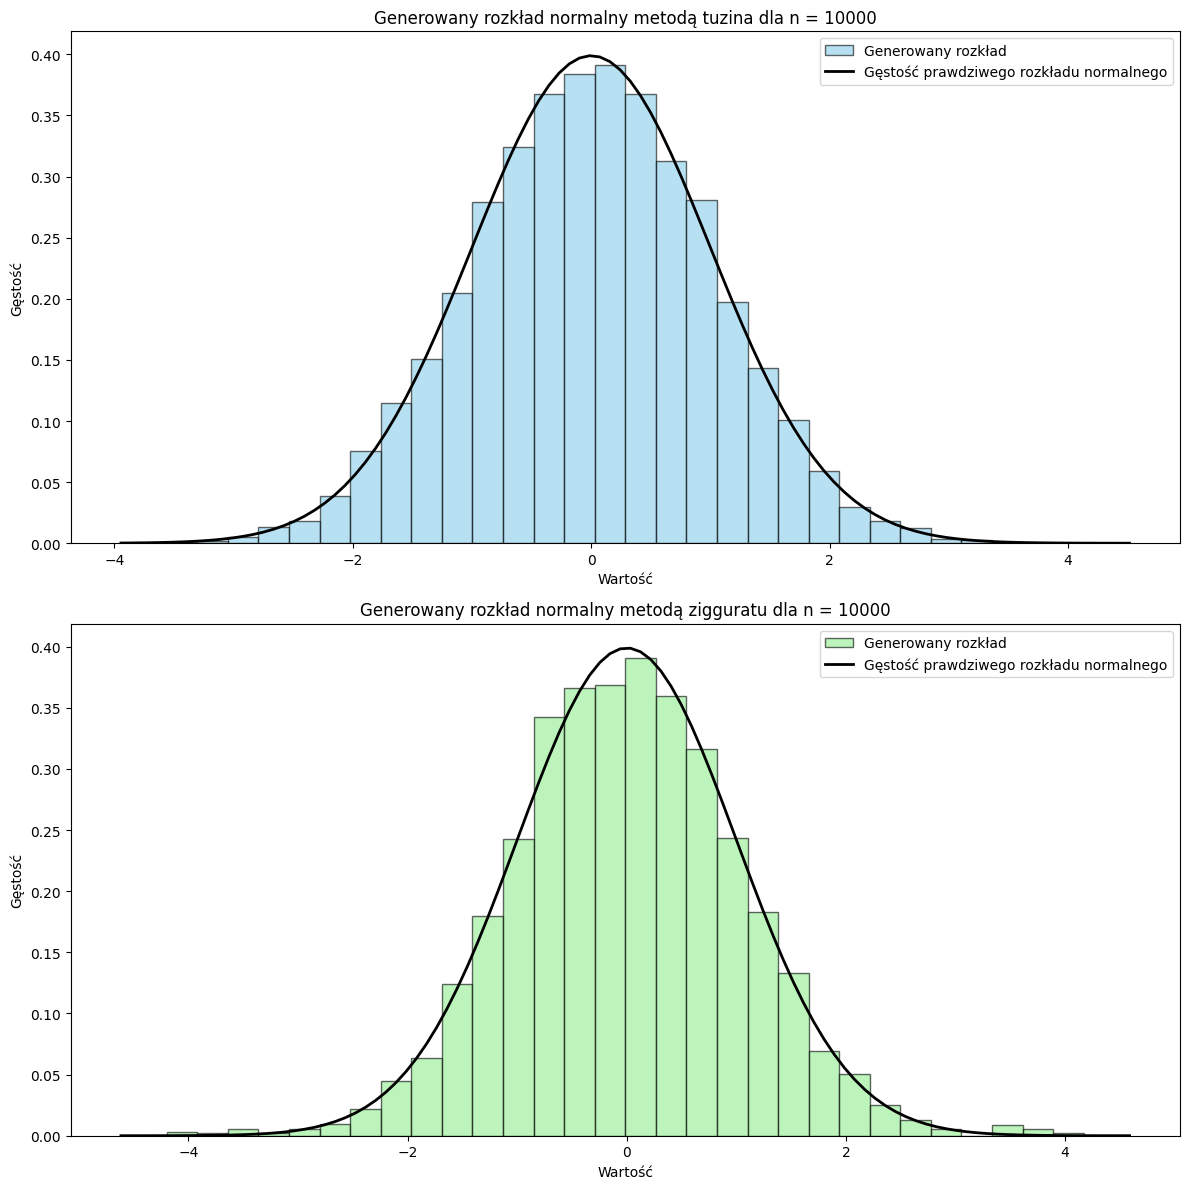

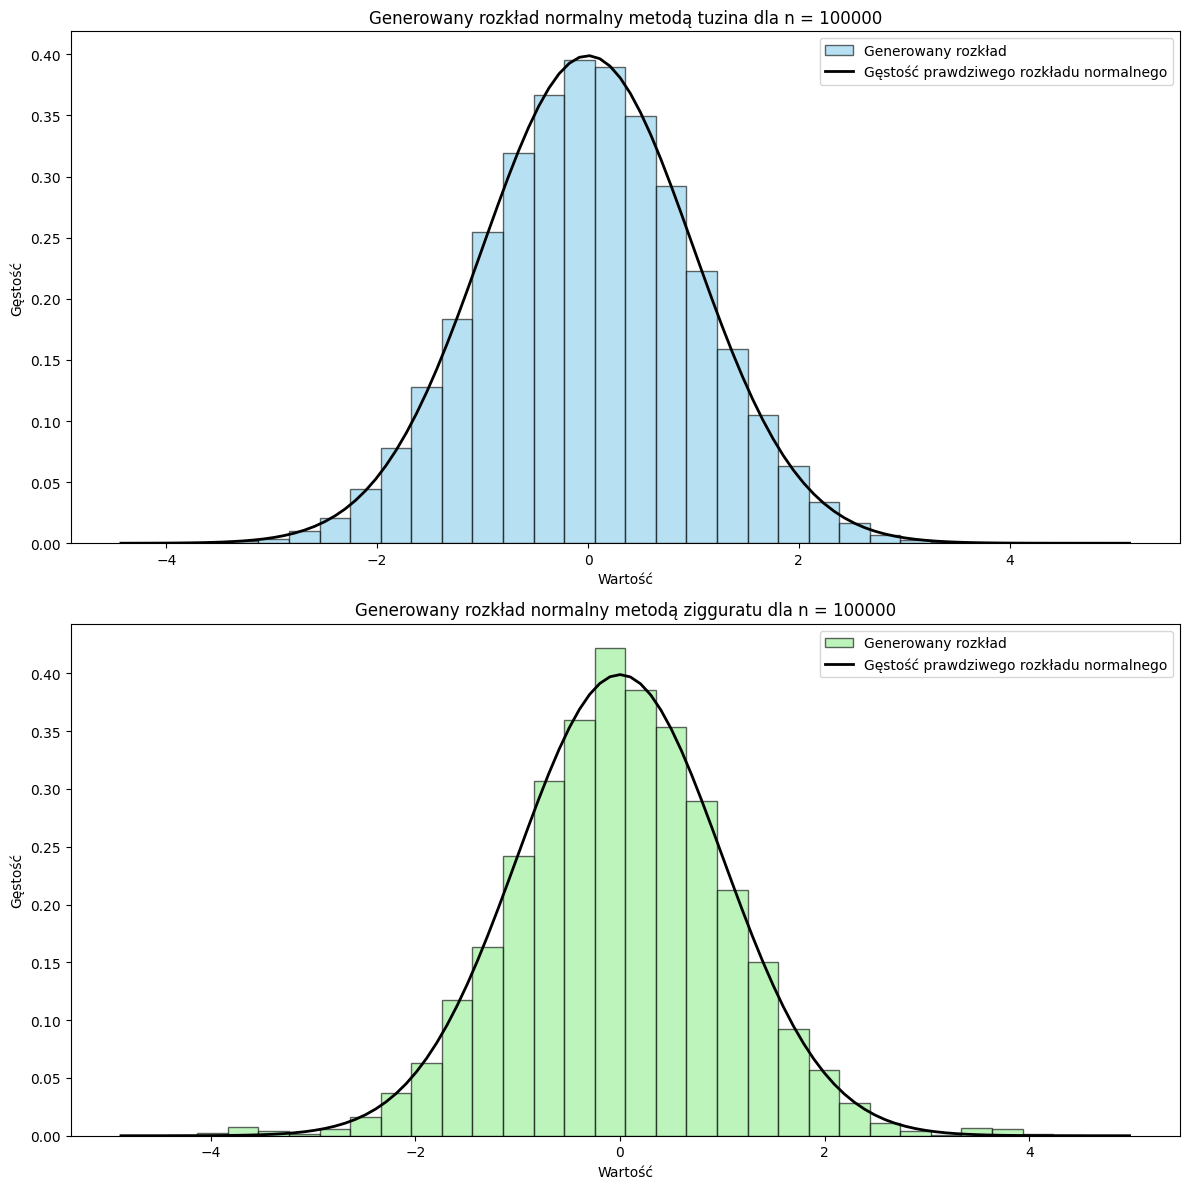

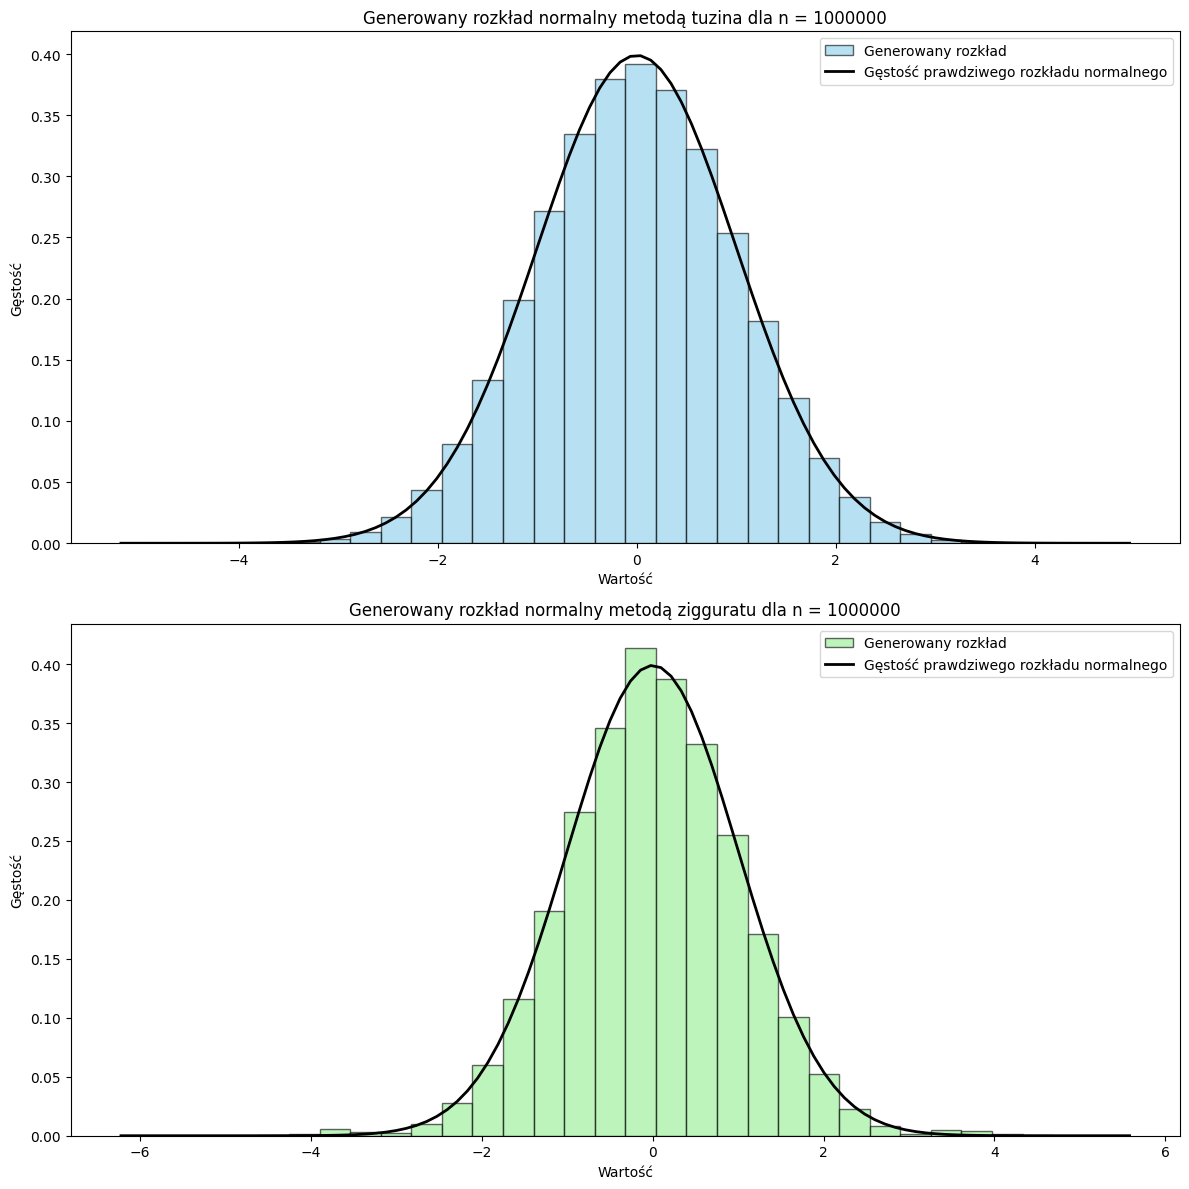

In [74]:
# Parametry
n_tuzin = 12  # Liczba liczb pseudolosowych dla metody tuzina
m = 0  # Średnia rozkładu normalnego
s = 1  # Odchylenie standardowe rozkładu normalnego

# Funkcja do porównania metod dla różnych liczności próbek
def compare_methods(sample_sizes):
    results = {}
    for num_samples in sample_sizes:
        
        
        # Pomiar czasu wykonania dla metody tuzina
        start_time_tuzin = time.time()
        samples_tuzin = [tuzin_method(n_tuzin, m, s) for _ in range(num_samples)]
        end_time_tuzin = time.time()
        execution_time_tuzin = end_time_tuzin - start_time_tuzin
        
        samples_tuzin = np.array(samples_tuzin)
        
        # Pomiar czasu wykonania dla metody zigguratu
        x, y = initialize_tables(256)
        start_time_ziggurat = time.time()
        samples_ziggurat = [ziggurat_normal(x, y) for _ in range(num_samples)]
        end_time_ziggurat = time.time()
        execution_time_ziggurat = end_time_ziggurat - start_time_ziggurat
        
        samples_ziggurat = np.array(samples_ziggurat)
        samples_ziggurat = samples_ziggurat[~np.isnan(samples_ziggurat)]  # Usuwanie NaN
        samples_ziggurat = samples_ziggurat[np.isfinite(samples_ziggurat)]  # Usuwanie nieskończonych wartości
       
        
        results[num_samples] = {
            'tuzin': {
                'samples': samples_tuzin,
                'time': execution_time_tuzin,
            
            },
            'ziggurat': {
                'samples': samples_ziggurat,
                'time': execution_time_ziggurat,
                
            }
        }
    return results

# Definiowanie różnych liczności próbek do przetestowania
sample_sizes = [1000,10000, 100000, 1000000]

# Porównanie metod
results = compare_methods(sample_sizes)

# Rysowanie histogramów i gęstości dla różnych liczności próbek
for num_samples in sample_sizes:
    samples_tuzin = results[num_samples]['tuzin']['samples']
    samples_ziggurat = results[num_samples]['ziggurat']['samples']
    
    plt.figure(figsize=(12, 12))
    
    # Metoda tuzina
    plt.subplot(2, 1, 1)
    plt.hist(samples_tuzin, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Generowany rozkład')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, m, s)
    plt.plot(x, p, 'k', linewidth=2, label='Gęstość prawdziwego rozkładu normalnego')
    plt.title(f'Generowany rozkład normalny metodą tuzina dla n = {num_samples}')
    plt.xlabel('Wartość')
    plt.ylabel('Gęstość')
    plt.legend()
    
    # Metoda zigguratu
    plt.subplot(2, 1, 2)
    plt.hist(samples_ziggurat, bins=30, density=True, alpha=0.6, color='lightgreen', edgecolor='black', label='Generowany rozkład')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, m, s)
    plt.plot(x, p, 'k', linewidth=2, label='Gęstość prawdziwego rozkładu normalnego')
    plt.title(f'Generowany rozkład normalny metodą zigguratu dla n = {num_samples}')
    plt.xlabel('Wartość')
    plt.ylabel('Gęstość')
    plt.legend()
    
    plt.tight_layout()
    
    # Wyświetlanie czasów wykonania
    print(f"Dla n = {num_samples}:")
    print(f"Metoda tuzina - czas wykonania: {results[num_samples]['tuzin']['time']:.6f} sekund")
    print(f"Metoda zigguratu - czas wykonania: {results[num_samples]['ziggurat']['time']:.6f} sekund")

Metoda tuzina jest generalnie szybsza niż metoda zigguratu dla wszystkich badanych liczności próbek (n). Różnica w czasie wykonania staje się bardziej zauważalna wraz ze wzrostem ich liczby. Generowane rozkłady wraz ze wzrostem liczby próbek stają się bardziej dokładne, co szczególnie widać dla liczby próbek równej 1000 i 1000000.

Użyjemy teraz dwóch testów statystycznych: Kołmogorowa-Smirnowa i Shapiro-Wilka, by porównać dokładność generowanych rozkładów metodą "tuzina" i "zigguratu" względem rozkładu normalnego.

W tym bloku kodu definiujemy kluczowe parametry, by testy były wykonywany dokładnie na tym samych próbkach. Warto zwrócić uwagę na parametr `alfa`, który określa poziom istotności testu statystycznego, tutaj ustawiony na 0.05. Jest to standardowa wartość używana w statystyce, oznaczająca 5% ryzyko błędu pierwszego rodzaju. Oznacza to, że istnieje 5% szans na odrzucenie hipotezy zerowej, gdy jest ona prawdziwa. Innymi słowy, jeśli p-wartość uzyskana z testu jest mniejsza niż, hipoteza zerowa zostanie odrzucona na korzyść hipotezy alternatywnej.


In [112]:
alfa = 0.05  
sample_sizes = [10, 100,1000, 10000,100000]  
samples = {}

for num_samples in sample_sizes:
    # Generowanie próbek metodą tuzina
    samples_tuzin = [tuzin_method(n_tuzin, m, s) for _ in range(num_samples)]
    samples_tuzin = np.array(samples_tuzin)

    # Generowanie próbek metodą zigguratu
    x, y = initialize_tables(256)
    samples_ziggurat = [ziggurat_normal(x, y) for _ in range(num_samples)]
    samples_ziggurat = np.array(samples_ziggurat)
    samples_ziggurat = samples_ziggurat[~np.isnan(samples_ziggurat)]  # Usuwanie NaN
    samples_ziggurat = samples_ziggurat[np.isfinite(samples_ziggurat)]  # Usuwanie nieskończonych wartości

    # Zapis próbek do słownika
    samples[num_samples] = {
        'tuzin': samples_tuzin,
        'ziggurat': samples_ziggurat
    }

#### Test Kołmogorowa-Smirnowa
Test Kołmogorowa-Smirnowa (KS) jest nieparametrycznym testem statystycznym służącym do porównywania dwóch dystrybuant empirycznych lub porównywania jednej dystrybuanty empirycznej z dystrybuantą teoretyczną.
##### Hipotezy
- **Hipoteza zerowa (H0):** Próbki pochodzą z tego samego rozkładu (w przypadku dwóch próbek) lub próbka pochodzi z określonego rozkładu teoretycznego.
- **Hipoteza alternatywna (H1):** Próbki pochodzą z różnych rozkładów lub próbka nie pochodzi z określonego rozkładu teoretycznego.

##### Metodologia
Dla danej próbki oblicza się dystrybuantę empiryczną $F_n(x)$, która jest skumulowaną funkcją rozkładu z próby. Dla drugiej próbki (lub teoretycznego rozkładu) oblicza się odpowiednio $G_m(x)$. 

Statystyka testu KS, $D $, jest zdefiniowana jako największa różnica (supremum) między tymi dystrybuantami:
$D = \sup_x |F_n(x) - G_m(x)|$

##### Wartość p
Wartość p w teście KS określa prawdopodobieństwo uzyskania statystyki testowej $ D$ o danej wartości (lub bardziej ekstremalnej) pod warunkiem, że hipoteza zerowa jest prawdziwa. Mała wartość p (np. poniżej ustalonego poziomu istotności alfa) sugeruje odrzucenie hipotezy zerowej na rzecz hipotezy alternatywnej.

In [113]:
# Funkcja do przeprowadzenia testu Kołmogorowa-Smirnowa
def compare_methods_with_ks(samples):
    results = {}
    for num_samples in samples:
        samples_tuzin = samples[num_samples]['tuzin']
        samples_ziggurat = samples[num_samples]['ziggurat']
        
        # Test Kołmogorowa-Smirnowa
        ks_stat_tuzin, p_value_tuzin = kstest(samples_tuzin, 'norm', args=(m, s))
        ks_stat_ziggurat, p_value_ziggurat = kstest(samples_ziggurat, 'norm', args=(m, s))
        
        results[num_samples] = {
            'tuzin': {
                'ks_stat': ks_stat_tuzin,
                'p_value': p_value_tuzin
            },
            'ziggurat': {
                'ks_stat': ks_stat_ziggurat,
                'p_value': p_value_ziggurat
            }
        }
    return results

# Przeprowadzanie testu KS
results_with_ks = compare_methods_with_ks(samples)

# Wyświetlanie wyników testu KS
for num_samples in sample_sizes:
    print(f"Dla n = {num_samples}:")
    tuzin_stat = results_with_ks[num_samples]['tuzin']['ks_stat']
    tuzin_p = results_with_ks[num_samples]['tuzin']['p_value']
    ziggurat_stat = results_with_ks[num_samples]['ziggurat']['ks_stat']
    ziggurat_p = results_with_ks[num_samples]['ziggurat']['p_value']
    
    print(f"Metoda tuzina - KS statystyka: {tuzin_stat:.6f}, p-wartość: {tuzin_p:.6f}")
    print(f"Metoda zigguratu - KS statystyka: {ziggurat_stat:.6f}, p-wartość: {ziggurat_p:.6f}")
    
    print("Interpretacja:")
    if tuzin_p > alfa:
        print(f"Metoda tuzina: Brak podstaw do odrzucenia hipotezy zerowej.Rozkład wygenerowany metodą tuzina jest zgodny z rozkładem normalnym.")
    else:
        print(f"Metoda tuzina: Odrzucenie hipotezy zerowej.Rozkład wygenerowany metodą tuzina nie jest zgodny z rozkładem normalnym.")
    
    if ziggurat_p > alfa:
        print(f"Metoda zigguratu: Brak podstaw do odrzucenia hipotezy zerowej.Rozkład wygenerowany metodą zigguratu jest zgodny z rozkładem normalnym.")
    else:
        print(f"Metoda zigguratu: Odrzucenie hipotezy zerowej.Rozkład wygenerowany metodą zigguratu nie jest zgodny z rozkładem normalnym.")
    print("----------------------------------------------------------------------------------------------------------------------------")

Dla n = 10:
Metoda tuzina - KS statystyka: 0.194775, p-wartość: 0.775439
Metoda zigguratu - KS statystyka: 0.544971, p-wartość: 0.063784
Interpretacja:
Metoda tuzina: Brak podstaw do odrzucenia hipotezy zerowej.Rozkład wygenerowany metodą tuzina jest zgodny z rozkładem normalnym.
Metoda zigguratu: Brak podstaw do odrzucenia hipotezy zerowej.Rozkład wygenerowany metodą zigguratu jest zgodny z rozkładem normalnym.
----------------------------------------------------------------------------------------------------------------------------
Dla n = 100:
Metoda tuzina - KS statystyka: 0.070639, p-wartość: 0.673907
Metoda zigguratu - KS statystyka: 0.147896, p-wartość: 0.177876
Interpretacja:
Metoda tuzina: Brak podstaw do odrzucenia hipotezy zerowej.Rozkład wygenerowany metodą tuzina jest zgodny z rozkładem normalnym.
Metoda zigguratu: Brak podstaw do odrzucenia hipotezy zerowej.Rozkład wygenerowany metodą zigguratu jest zgodny z rozkładem normalnym.
------------------------------------------

#### Test Shapiro-Wilka
Test Shapiro-Wilka jest parametrycznym testem statystycznym stosowanym do oceny normalności rozkładu danych. Jest jednym z najbardziej czułych testów do wykrywania odchyleń od normalności, zwłaszcza w przypadku małych próbek.
##### Hipotezy
- **Hipoteza zerowa (H0):** Dane pochodzą z rozkładu normalnego.
- **Hipoteza alternatywna (H1):** Dane nie pochodzą z rozkładu normalnego.

##### Metodologia
Test Shapiro-Wilka opiera się na analizie wartości uporządkowanych w próbie i porównaniu ich z odpowiadającymi im wartościami oczekiwanymi dla próbki z rozkładu normalnego.

Statystyka testu Shapiro-Wilka, $ W $, jest obliczana jako stosunek kwadratu sumy odpowiednio ważonych wartości uporządkowanych do sumy kwadratów odchyleń od średniej:
 $\large  W = \frac{\left( \sum_{i=1}^{n} a_i x_{(i)} \right)^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2}$ 
Gdzie:
- $ x_{(i)}$ to uporządkowane wartości próbki.
- $ a_i $ to odpowiednie wagi obliczane na podstawie wartości oczekiwanych dla normalnego rozkładu standardowego.
- $\bar{x}$ to średnia arytmetyczna próby.

##### Wartość p
 Anaglogicznie jak w pzypadku poprzedniego testu wartość p w teście Shapiro-Wilka określa prawdopodobieństwo uzyskania statystyki testowej $ W$ o danej wartości (lub bardziej ekstremalnej) pod warunkiem, że hipoteza zerowa jest prawdziwa. Mała wartość p (np. poniżej ustalonego poziomu istotności alfa) sugeruje odrzucenie hipotezy zerowej na rzecz hipotezy alternatywnej.

In [114]:
# Funkcja do przeprowadzenia testu Shapiro-Wilka
def compare_methods_with_shapiro(samples):
    results = {}
    for num_samples in samples:
        samples_tuzin = samples[num_samples]['tuzin']
        samples_ziggurat = samples[num_samples]['ziggurat']
        
        # Test Shapiro-Wilka
        shapiro_stat_tuzin, p_value_tuzin = shapiro(samples_tuzin)
        shapiro_stat_ziggurat, p_value_ziggurat = shapiro(samples_ziggurat)
        
        results[num_samples] = {
            'tuzin': {
                'shapiro_stat': shapiro_stat_tuzin,
                'p_value': p_value_tuzin
            },
            'ziggurat': {
                'shapiro_stat': shapiro_stat_ziggurat,
                'p_value': p_value_ziggurat
            }
        }
    return results

# Przeprowadzanie testu Shapiro-Wilka
results_with_shapiro = compare_methods_with_shapiro(samples)

# Wyświetlanie wyników testu Shapiro-Wilka
for num_samples in sample_sizes:
    print(f"Dla n = {num_samples}:")
    tuzin_stat = results_with_shapiro[num_samples]['tuzin']['shapiro_stat']
    tuzin_p = results_with_shapiro[num_samples]['tuzin']['p_value']
    ziggurat_stat = results_with_shapiro[num_samples]['ziggurat']['shapiro_stat']
    ziggurat_p = results_with_shapiro[num_samples]['ziggurat']['p_value']
    
    print(f"Metoda tuzina - Shapiro-Wilk statystyka: {tuzin_stat:.6f}, p-wartość: {tuzin_p:.6f}")
    print(f"Metoda zigguratu - Shapiro-Wilk statystyka: {ziggurat_stat:.6f}, p-wartość: {ziggurat_p:.6f}")
    
    # Interpretacja wyników
    print("Interpretacja testu Shapiro-Wilka:")
    if tuzin_p > alfa:
        print(f"Metoda tuzina: Brak podstaw do odrzucenia hipotezy zerowej.Rozkład wygenerowany metodą tuzina jest zgodny z rozkładem normalnym.")
    else:
        print(f"Metoda tuzina: Odrzucenie hipotezy zerowej.Rozkład wygenerowany metodą tuzina nie jest zgodny z rozkładem normalnym.")
    
    if ziggurat_p > alfa:
        print(f"Metoda zigguratu: Brak podstaw do odrzucenia hipotezy zerowej.Rozkład wygenerowany metodą zigguratu jest zgodny z rozkładem normalnym.")
    else:
        print(f"Metoda zigguratu: Odrzucenie hipotezy zerowej.Rozkład wygenerowany metodą zigguratu nie jest zgodny z rozkładem normalnym.")
    print("----------------------------------------------------------------------------------------------------------------------------")

Dla n = 10:
Metoda tuzina - Shapiro-Wilk statystyka: 0.922664, p-wartość: 0.379709
Metoda zigguratu - Shapiro-Wilk statystyka: 0.823495, p-wartość: 0.124210
Interpretacja testu Shapiro-Wilka:
Metoda tuzina: Brak podstaw do odrzucenia hipotezy zerowej.Rozkład wygenerowany metodą tuzina jest zgodny z rozkładem normalnym.
Metoda zigguratu: Brak podstaw do odrzucenia hipotezy zerowej.Rozkład wygenerowany metodą zigguratu jest zgodny z rozkładem normalnym.
----------------------------------------------------------------------------------------------------------------------------
Dla n = 100:
Metoda tuzina - Shapiro-Wilk statystyka: 0.985473, p-wartość: 0.343337
Metoda zigguratu - Shapiro-Wilk statystyka: 0.969868, p-wartość: 0.199207
Interpretacja testu Shapiro-Wilka:
Metoda tuzina: Brak podstaw do odrzucenia hipotezy zerowej.Rozkład wygenerowany metodą tuzina jest zgodny z rozkładem normalnym.
Metoda zigguratu: Brak podstaw do odrzucenia hipotezy zerowej.Rozkład wygenerowany metodą ziggura

#### Winoski z przeprowadzonych  testów statystycznych
Analiza wyników testów Kołmogorowa-Smirnowa i Shapiro-Wilka wskazuje, że dla małych próbek (n = 10, 100, 1000), zarówno metoda tuzina, jak i metoda zigguratu generują rozkłady zgodne z normalnym. Jednakże, w przypadku dużych próbek (n = 10,000 i więcej), wyniki testu Shapiro-Wilka sugerują, że rozkłady wygenerowane obiema metodami nie są zgodne z rozkładem normalnym. Wyniki te podkreślają ograniczenia obu metod przy generowaniu dużych zbiorów danych, co może wpłynąć na ich użyteczność w bardziej wymagających analizach statystycznych. Ogólnie rzecz biorąc, wyniki wskazują na konieczność dokładnej weryfikacji normalności rozkładów, szczególnie w kontekście dużych próbek, aby zapewnić poprawność wniosków w dalszych analizach.

### Podsumowanie
Biorąc pod uwagę oba kryteria:
- Czas wykonania: Metoda tuzina jest bardziej wydajna i szybsza w generowaniu dużych próbek.
- Dokładność symulacji: Obie metody są porównywalne dla małych próbek. Dla dużych próbek, test Shapiro-Wilka wykazuje pewne ograniczenia obu metod w generowaniu idealnie normalnych rozkładów.

Podsumowując, metoda tuzina okazuje się bardziej efektywna pod względem czasu wykonania, szczególnie dla dużych próbek, podczas gdy obie metody wykazują podobną dokładność dla małych próbek. Przy generowaniu dużych zbiorów danych zaleca się dodatkową weryfikację normalności rozkładów, aby zapewnić dokładność wyników analiz statystycznych.

# Zadanie 3: Metody redukcji wariancji 

## Treść zadania

Zapoznaj się z metodami redukcji wariancji w metodach Monte Carlo: https://en.wikipedia.org/wiki/Variance_reduction. W szczególności skupimy się na dwóch metodach:

• metoda odbić lustrzanych https://en.wikipedia.org/wiki/Antithetic_variates

• metoda zmiennej kontrolnej https://en.wikipedia.org/wiki/Control_variates

Krok 1.

Metodą Monte Carlo oblicz całkę
$$
\int _0^1 \frac{4}{1+x^2}dx
$$
(szacowanie liczby $\pi$)

Krok 2.

Zastostuj jedną z metod redukcji wariancji do ponownego obliczenia zadanej całki.

Krok 3.

Przedstaw analizę błędu względem ilości symulacji w formie tabeli lub wykresu.

<br>

## Rozwiązanie


Naszym celem jest przybliżenie liczby $\pi$, poprzez obliczanie całki
$$
\int_0^1 \frac{4}{1+x^2} dx,
$$
za pomocą metody Monte Carlo. Wykorzystamy dwie metody, dzięki którym zmniejszymy wariancję otrzymywanych wyników. W celu obliczenia tej całki generujemy liczbę $X$ z rozkładu jednostajnego na przedziale $[0,1]$. Następnie liczbę tą wstawiamy w funkcję $f$ zawartą w całce. Proces ten powtarzamy $n$ razy, a naszym wynikiem będzie średnia ze wszystkich pomiarów. W poniższym kodzie definiujemy funkcję podcałkową $f$:

In [12]:
def f(x):
    """ 
    Funkcja podcałkowa
    """
    return 4/(1+x**2)



### Metoda odbić lustrzanych
Metoda odbić lustrzanych polega na tworzeniu dodatkowej liczby losowej, $1-X$, gdzie $X$ jest liczbą wylosowaną z rozkładu jednostajnego na odcinku $[0,1]$.
Otrzymana liczba również będzie z tego przedziału.
Oznaczymy ją jako X'.
Naszym nowym estymatorem liczby $\pi$ będzie średnia wyników funkcji $f$ tych liczb.
$$
\theta = \frac{f(X)+f(X')}{2}
$$
Wartość oczekiwana jest taka sama jak przy metodzie Monte Carlo dla podwójnej ilości pomiarów, jednak znacząca różnica występuje przy liczeniu wariancji.
W tym przypadku para $X, X'$ ma wobec siebie ujemną zależność, zatem przy liczeniu ich wariancji należy zastosować wzór: 
$$
Var(\theta) = \frac{Var(f(X)) + Var(f(X')) + 2Cov(f(X),f(X'))}{4},
$$
gdzie kowariancja $X$ i $X'$ będzie ujemna, zatem całkowita wariancja się zmniejszy.
Niżej zdefiniowaliśmy funkcję obliczającą 

In [13]:
def mirror(n):
    """
    Oblicza n przybliżonych wartości całki metodą odbić lustrzanych
    """
    u1 = np.random.random(n)
    u2 = 1 - u1

    f_u1 = f(u1)
    f_u2 = f(u2)
    f_u = (f_u1+f_u2)/2
    return f_u


### Metoda zmiennej kontrolnej
Metoda zmiennej kontrolnej polega na wykorzystaniu estymatora cechy, której wartość znamy, w celu zmniejszenia wariancji estymatora cechy, której wartość chcemy przybliżyć. 
Niech $m$ będzie estymatorem nieznanego wyniku całki
$$
\int_0^1 \frac{4}{1+x^2} dx,
$$
Jako zmienną kontrolną zdefiniujemy znany nam wynik całki:
$$
\int_0^1 1+x^2 dx = \frac{4}{3},
$$
której estymatorem będzie $t$:
$$
t = 1+U^2 .
$$
Wykorzystując zdefiniowane wyżej wartości stworzymy nowy estymator:
$$
m^* = m + c(t-\frac{4}{3}).
$$
Wartość oczekiwana tego estymatora jest taka sama jak dla $m$, ponieważ $\mathbb{E}[t] - \mathbb{E}[\frac{4}{3}] = 0$. 
Z kolei wariancja tego estymatora będzie zależna od $c$. Aby zminimalizować wariancję, c powinno wynosić:
$$
c = -\frac{Cov(m,t)}{Var(t)}
$$
Podstawiając to pod wzór otrzymujemy nowy estymator o tej samej wartości oczekiwanej lecz zmniejszonej wariancji.
Niżej zdefiniowaliśmy funkcje potrzebne do wykorzystania tej metody.

In [14]:
def g(x):
    """Funckja zmiennej kontrolnej"""
    return 1+x**2

def control(n):
    """
    Oblicza n przybliżonych wartości całki metodą zmiennej kontrolnej
    """
    tau = 4/3 #analityczny wynik całki / wartość oczekiwana g(U) 
    
    u = np.random.random(n)

    probe_f = f(u)
    probe_g = g(u)

    covariance = np.cov(probe_f,probe_g)[0][1]

    c = -1*covariance/np.var(probe_g)
    return probe_f+c*(probe_g-tau)

W kolejnym kroku będziemy chcieli przedstawić efektywność naszych metod. Za pomocą każdej z nich wygenerujemy $n$ wartości i zobaczymy czy ich średnia jest równa $\pi$, jaką mają wariancję oraz za pomocą violinplot'a jak bardzo rozległe są wyniki.

In [15]:
n=1500
est1 = f(np.random.random(2*n))
print(np.mean(est1),np.var(est1))
est2 = control(2*n)
print(np.mean(est2),np.var(est2))
est3 = mirror(n)
print(np.mean(est3),np.var(est3))

3.1513317577262034 0.41542848686465506
3.1412507407763175 0.012627685098726
3.1409571114647576 0.0034119725336793443


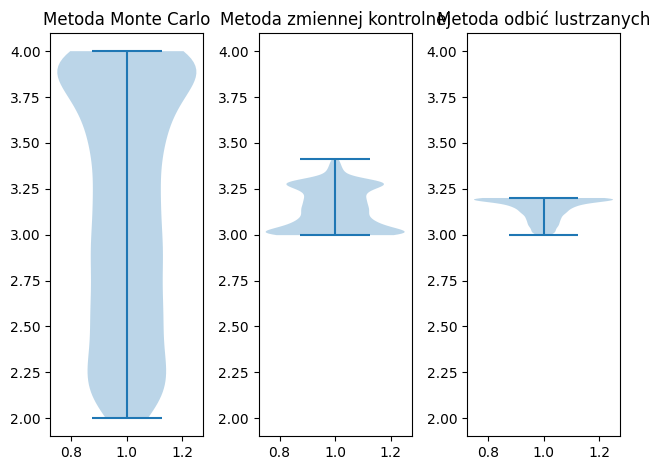

In [16]:
plot1 = plt.subplot2grid((1,3),(0,0))
plt.violinplot(est1)
plot1.set_title("\n".join(wrap("Metoda Monte Carlo", 20)))
plot2 = plt.subplot2grid((1,3),(0,1))
plt.violinplot(est2)
plot2.set_title("\n".join(wrap("Metoda zmiennej kontrolnej", 20)))
plot2.set_ylim(plot1.get_ylim())
plot3 = plt.subplot2grid((1,3),(0,2))
plt.violinplot(est3)
plot3.set_title("\n".join(wrap("Metoda odbić lustrzanych", 20)))
plot3.set_ylim(plot1.get_ylim())
plt.tight_layout()

Na powyższym wykresie widać, że obydwie metody zwracając wyniki w dużo mniejszym przedziale niż tradycyjna metoda Monte Carlo.
Następnie chcielibyśmy sprawdzić jak bardzo wielkość próby, z której średnią przyjmiemy za wynik, wpływa na jego dokładność.
Dlatego dla 100 równo rozłożonych wartości $n$ z przedziału $[1000,100000]$ obliczymy średnią z naszych prób i zobaczymy czy wynik będzie stawał się dokładniejszy.

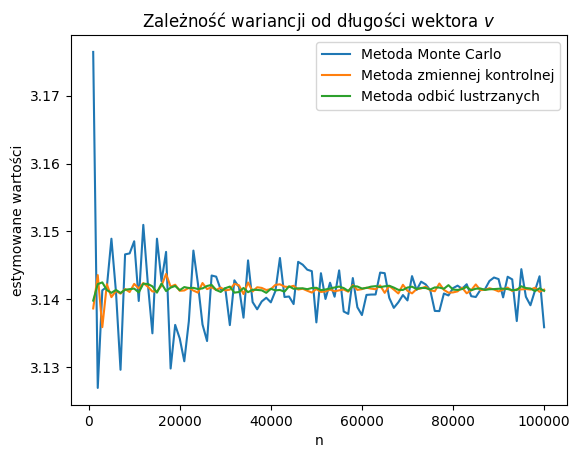

In [73]:
sample_sizes = np.arange(1,101)*1000
estims1=np.zeros(100)
estims2=np.zeros(100)
estims3=np.zeros(100)

for i in range(100):
    estims1[i] = np.mean(f(np.random.random(sample_sizes[i])))
    estims2[i] = np.mean(control(sample_sizes[i]))
    estims3[i] = np.mean(mirror(sample_sizes[i]))

plot = plt.subplot()
plt.plot(sample_sizes,estims1, label = "Metoda Monte Carlo")
plt.plot(sample_sizes,estims2, label = "Metoda zmiennej kontrolnej")
plt.plot(sample_sizes,estims3, label = "Metoda odbić lustrzanych")
plot.set_xlabel("n")
plot.set_ylabel("estymowane wartości")
plt.title("Zależność wariancji od długości wektora $v$")
plt.legend()
plt.show()

Na tym wykresie widać, że skoki dla metody Monte Carlo są dużo większe dla prób o mniejszych rozmiarach. Wyniki dla metody zmiennej kontrolnej są tylko trochę bardziej rozległe dla mniejszych prób, zaś metoda odbić lustrzanych daje stale dokładne wyniki.

# Zadanie 4: Warunkowa wartość oczekiwana 

## Treść zadania

Wartość oczekiwana f(X) zmiennej Y warunkowanej zmienną X ma bardzo ciekawą interpretację, mianowicie spełnia własność

$$
E(Y|X\ =\ x)\ =\ f(x)\ =\ \arg \min_g E ((Y - g(X))^2).
$$

Oznacza to, że E (Y |X) to najlepsze przybliżenie w sensie $L^2$ zmiennej $Y$ korzystające z danych pochodzących ze zmiennej $X$. Sprawdź symulacyjnie następujące stwierdzenia

- <b>a.</b> Jeśli $X$,$Y$ są zmiennymi niezależnymi a $E(Y) = 0$, to dla $Z = XY + \sin X$ zachodzi $E(Z|X) = \sin X$. Jako przykład zaprezentujemy $X$, $Y$ iid ~ $N(0,1)$. Zrób scatterplot $X → E(Z|X)$ wysymulowanych wartości i zaznacz na nim wartości estymowane oraz teoretyczne $E(Z|X)$.

-  <b>b.</b> Gdy $N$ jest procesem Poissona o intensywnosci $\lambda$, to dla $T \ge t \ge 0$ zachodzi $E(N_t|N_T) = \frac{tN_T}{T}$. Oznacza to, że np. zakładając przybywanie klientów do sklepu zgodnie z procesem Poissona i mając dane na temat dotychczasowej ilości klientów w sklepie w chwili $T$ (czyli $N_T$), to najlepszym przybliżeniem dotychczasowej chwili klientów w chwili $t \lt T$ równej $N_t$ jest $\frac{tN_T}{T}$. Jako przykład możesz wziąć np. $T = 1$, $\lambda = 10$ (zależnie od
metody, niekoniecznie potrzebujesz parametru intensywności). Zrób wykres $t → E(N_t|N_T)$ dla kilku możliwych realizacji $N_T$ i zaznacz na nim wartości estymowane.

- <b>c.</b> Gdy $N$ jest procesem Poissona o intensywnosci $\lambda$, to dla $t \ge s \ge 0$ zachodzi $E(N_t|F_s) = N_s + \lambda(t −s)$, gdzie $F_s$ to filtracja naturalna procesu $N_s$. Oznacza to, że np. zakładając przybywanie klientów do sklepu zgodnie z procesem Poissona i mając dane na temat dotychczasowej ilości klientów w sklepie w każdej chwili $\omega$ spełniającej $0 \ge ω \ge s$ (czyli $F_s$), to najlepszym przybliżeniem dotychczasowej chwili klientów w chwili $t \ge s$ jest $N_s + \lambda (t−s)$. Jako przykład możesz wziąć np. $s = 1$, $\lambda = 10$. Zrób wykres $t → E(N_t|F_s)$ dla kilku możliwych realizacji $N_s$, $s \ge t$, i zaznacz na nim wartości estymowane. Podpowiedź: Wygeneruj kilka trajektorii $N_\omega$, $\omega \ge s$ i wybierz z nich te, które przybierają różne wartości $N_s$ (w tym kroku nie potrzebowałeś użycia parametru intensywności). Następnie skorzystaj z własności Markowa i dla każdej z wybranych realizacji $N_\omega$, $\omega \ge s$ dosymuluj trajektorie $N_\omega$ dla $s \gt \omega \ge t$, za pomocą których wyestymuj $E(N_t|F_s)$.

<br>

## Rozwiązanie


### Ad. a.

Zadanie to rozpoczniemy od  wygerowania unikalnych $X$ ~ $N(0,1)$ 

In [2]:
n = 200
M = 2_000

In [3]:
X = []

while len(X) != n:
    X = np.random.normal(0, 1, n)
    X = list(set(X)) 
    X = sorted(X)

    n = len(X)

Przygotowaliśmy sobie zestaw unikalnych parametrów $X$, ponieważ podczas obliczania $E(Z|X)$ to $X$ będzie wartością nam znaną wedle której wygenerujemy zestaw "zetek".

Dlatego teraz przejdziemy przez każdą unikalną wartość $X$ i wygenerujemy dla niej $M$ razy wartość $Z|X$.

In [4]:
Z_based_on_X = {}

for x_i in X:
    Z_based_on_X[x_i] = np.zeros(M)

    for i in range(M):
        Y = np.random.normal(0, 1)

        Z_i = x_i * Y + np.sin(x_i) # Z = XY + sin(X)
        Z_based_on_X[x_i][i] = Z_i

Z_based_on_X_sorted = dict(sorted(Z_based_on_X.items()))


Wyświetlmy dane, które udało nam się uzyskać

In [5]:
x_plot_values = np.zeros(n * M)
y_plot_values = np.zeros(n * M)

index_for_scatter = 0

for x_i in Z_based_on_X_sorted:
    for y_i in Z_based_on_X_sorted[x_i]:
        x_plot_values[index_for_scatter] = x_i
        y_plot_values[index_for_scatter] = y_i

        index_for_scatter += 1

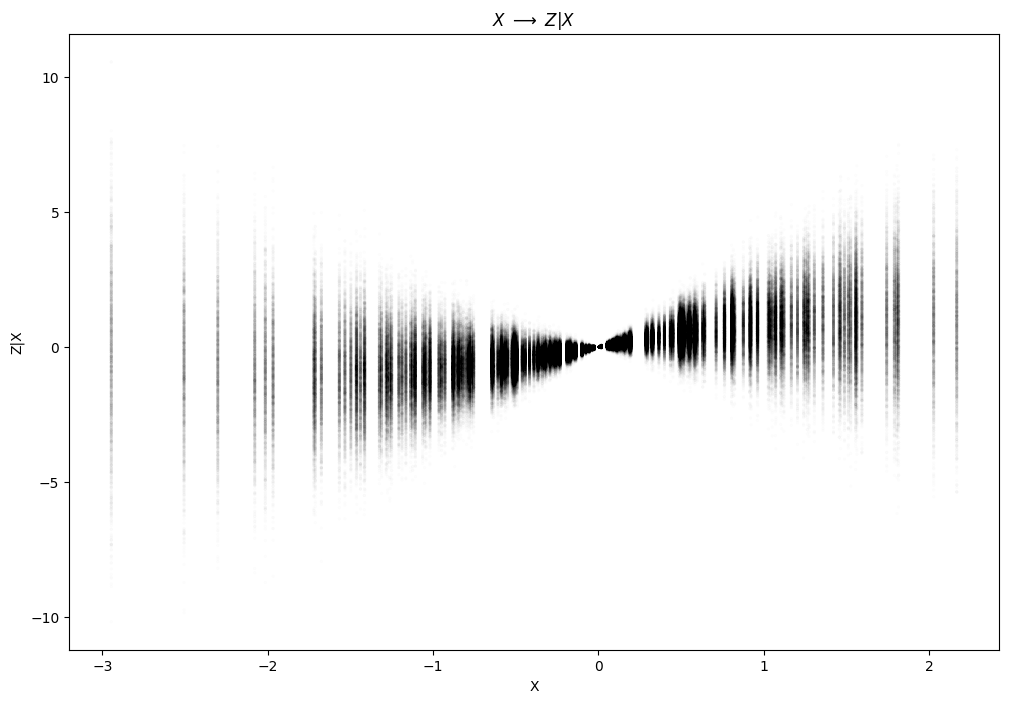

In [6]:
plt.figure(figsize=(12, 8))
plt.scatter(x_plot_values, y_plot_values, alpha=0.01, facecolors='none', edgecolors='black', s=2)
plt.title('$X$ $\\longrightarrow$ $Z|X$')
plt.xlabel('X')
plt.ylabel('Z|X')
plt.show()

Na tak przygotowanej "chmurze" danych chcielibyśmy zweryfikować empirycznie podaną własnosć, dla tego konkretnego przypadku $E(Z|X) = \sin X$.

Przygotujmy najpierw empirycznie obliczone wartości $E(Z|X)$ używając średniej jako estymatora.

In [7]:
expected_values_x = np.zeros(n)
expected_values_y = np.zeros(n)

index_for_expected_values = 0

for x_i in Z_based_on_X_sorted:

    expected_value_for_x_i = np.mean(Z_based_on_X_sorted[x_i]) 

    expected_values_x[index_for_expected_values] = x_i
    expected_values_y[index_for_expected_values] = expected_value_for_x_i

    index_for_expected_values += 1

I tak obliczony zestaw danych porównajmy na wykresie wraz z wskazanym rozwiązaniem teoretycznym

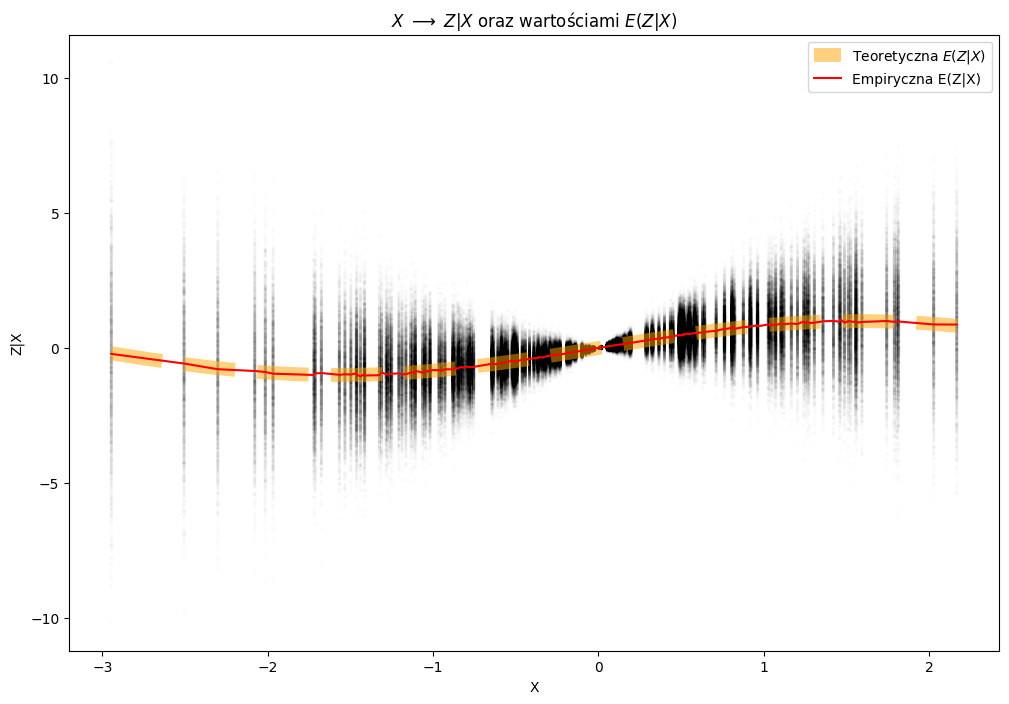

In [8]:
x_min, x_max = np.min(X), np.max(X)
x_range = np.linspace(x_min, x_max, n)

plt.figure(figsize=(12, 8))
plt.scatter(x_plot_values, y_plot_values, alpha=0.01, facecolors='none', edgecolors='black', s=2)
plt.plot(x_range, np.sin(x_range), '--', linewidth=10, c='orange', label="Teoretyczna $E(Z|X)$", alpha=0.5)
plt.plot(expected_values_x, expected_values_y, c='red', label="Empiryczna E(Z|X)")

plt.title('$X$ $\\longrightarrow$ $Z|X$ oraz wartościami $E(Z|X)$')
plt.xlabel('X')
plt.ylabel('Z|X')

plt.legend()
plt.show()


### Ad. b

#### Proces poissona

Implementacje tego zadania rozpoczniemy od przygotowania funkcji do generowania procesu poisonna. W celi uzyskania zestawu $N_t$ wykorzystamy algorytm:

1. Wygeneruj $k \sim Pois(\lambda t)$.
2. $N_t = U \cdot T$, gdzie $U$ to wektor $n$ elementowy $\sim U([0, 1]) \cdot T$
3. Posortuj $N_t$ rosnąco.

<b>Uwaga!</b> Zauważmy tutaj, że zgodnie z treścią naszego zadania znana jest nam aktualna liczba klientów $N_T$ - w takim razie każdy generowany przez nas proces Poissona powinien mieć $k = N_T$, zatem możemy uprościć nasz algorytm:

1. Weź $k = N_T$.
2. $N_t = U \cdot T$, gdzie $U$ to wektor $n$ elementowy $\sim U([0, 1]) \cdot T$
3. Posortuj $N_t$ rosnąco.

In [9]:
def get_poisson(T, k):
    """
    Generuje proces Poissona o długości T dla danej liczby zdarzeń k.
    """
    T_prime = np.random.uniform(1, 0, k) * T
    T_prime = np.sort(T_prime)
    
    return T_prime

Następnie, żeby zrealizować zadanie musimy ustawić podstawowe dane algorytmu. Dzięki implementacji generowania procesu Poissona bez wykorzystania parametru $\lambda$ nie musimy go przechowywać w naszym kodzie.

In [10]:
T = 1
N_T = 40

monte_carlo_steps_count = 100
time_steps_count = 1_000
time_range = np.linspace(0, T, time_steps_count)

Przy okazji inicjalizacji zadania i definiowania funkcji generującej proces Poissona - zdefiniujemy funkcję pomocniczą do tworzenia ładnych wykresów procesu Poissona

In [11]:
def plt_poisson_steps(N_t, T, c='blue', alpha=1, x0=0, y0=0):
    """
    Wyświetla kroki procesu Poissona na wykresie.

    Parametry:
    - N_t: Tablica zawierająca czasy przybycia zdarzeń w procesie Poissona.
    - T: Całkowity czas trwania procesu Poissona.
    - c: Kolor linii i punktów na wykresie (domyślnie 'blue').
    - alpha: Przezroczystość linii i punktów na wykresie (domyślnie 1).
    - x0: Początkowa wartość osi x (domyślnie 0).
    - y0: Początkowa wartość osi y (domyślnie 0).
    """
    x_i = [x0]
    y_i = [y0]

    for i in range(len(N_t)):
        x_i.append(N_t[i])
        y_i.append(y_i[-1] + 1)

        plt.vlines(x=x_i[-1], ymin=y_i[-1] - 1, ymax=y_i[-1], linestyles='dotted', linewidth=2, color=c, alpha=alpha)
        plt.hlines(y=y_i[-2], xmin=x_i[-2], xmax=x_i[-1], linewidth=2, color=c, alpha=alpha)
        plt.scatter(x=[x_i[-1]], y=[y_i[-2]], facecolors='none', edgecolors=c, s=40, alpha=alpha)
        plt.scatter(x=[x_i[-1]], y=[y_i[-1]], c=c, s=40, alpha=alpha)

    plt.hlines(y=y_i[-1], xmin=x_i[-1], xmax=T, linewidth=2, color=c, alpha=alpha)
    plt.scatter(x=[T], y=[y_i[-1]], c=c, s=40, alpha=alpha)

Naszym aktualnym zadanie pozostaje wygenerowanie z pomocą metody Monte Carlo wielu procesów Poissona, których $k = N_T$. Tak stworzone procesy zapiszemy w formie 2 wymiarowej tablicy `czas x ilość_klientów`, aby w późniejszych krokach wygodnie obliczyć wartości estymowane $E(N_t|N_T)$. Całość zaimplementujemy w następujący sposób:

<table>
  <caption>
    Schemat zapisu zmiennaej clients_over_time_per_simulation
  </caption>
  <tr>
    <th scope="row">Czas (t)</th>
    <td>0</td>
    <td>0.1</td>
    <td>0.2</td>
    <td>...</td>
  </tr>
  <tr>
    <th scope="row">Suma klientów (nr sym 1.)</th>
    <td>0</td>
    <td>0</td>
    <td>1</td>
    <td>...</td>
  </tr>
  <tr>
    <th scope="row">Suma klientów (nr sym 2.)</th>
    <td>1</td>
    <td>2</td>
    <td>3</td>
    <td>...</td>
  </tr>
  <tr>
    <th scope="row">Suma klientów (nr sym ...)</th>
    <td>0</td>
    <td>1</td>
    <td>2</td>
    <td>...</td>
  </tr>
</table>


In [12]:
def get_clients_over_time_per_simulation(T, N_T, monte_carlo_steps_count, time_range):
    """
    Generuje symulację liczby klientów w sklepie w różnych chwilach czasowych na podstawie procesu Poissona.

    Parametry:
    - T: Czas trwania symulacji (długość okresu) [float].
    - N_T: Liczba klientów w chwili T [int].
    - monte_carlo_steps_count: Liczba iteracji symulacji Monte Carlo [int].
    - time_range: Zakres czasowy symulacji

    Zwraca:
    - clients_over_time_per_simulation: Słownik, gdzie kluczem jest chwila czasowa, a wartością lista zawierająca
      symulowane liczby klientów w tej chwili czasowej dla każdej iteracji Monte Carlo.
    """
    clients_over_time_per_simulation = {} # (time_step) klucz -> (value) wartość

    for t in time_range:
        clients_over_time_per_simulation[t] = np.zeros(monte_carlo_steps_count)

    for index in range(monte_carlo_steps_count):
        N_t = get_poisson(T, N_T)

        total_clients = 0
        currently_checked_N_t = 0

        for t in time_range:
            while (
                currently_checked_N_t < len(N_t)
                and N_t[currently_checked_N_t] <= t
            ):
                total_clients += 1
                currently_checked_N_t += 1
            
            clients_over_time_per_simulation[t][index] = total_clients
    
    return clients_over_time_per_simulation

Z tak przygotowanymi danymi możemy obliczyć estymowaną wartość $E(N_T|N_t)$:

<table>
  <caption>
    Obliczanie estymowanej wartości
  </caption>
  <tr>
    <th scope="row">Czas (t)</th>
    <td>0</td>
    <td>0.1</td>
    <td>0.2</td>
    <td>...</td>
  </tr>
  <tr>
    <th scope="row" style="font-weight: normal">Suma klientów (nr sym 1.)</th>
    <td>0</td>
    <td>0</td>
    <td>1</td>
    <td>...</td>
  </tr>
  <tr>
    <th scope="row" style="font-weight: normal">Suma klientów (nr sym 2.)</th>
    <td>1</td>
    <td>2</td>
    <td>3</td>
    <td>...</td>
  </tr>
  <tr>
    <th scope="row" style="font-weight: normal">Suma klientów (nr sym 3.)</th>
    <td>0</td>
    <td>1</td>
    <td>2</td>
    <td>...</td>
  </tr>
  <tr>
    <th scope="row">Wartość estymowana (średnia)</th>
    <td>1/3</td>
    <td>3/3</td>
    <td>6/3</td>
    <td>...</td>
  </tr>
</table>


In [13]:
def get_clients_expected_values(clients_over_time_per_simulation, time_steps_count):
    """
    Oblicza wartości oczekiwane liczby klientów w sklepie w różnych chwilach czasowych.

    Parametry:
    - clients_over_time_per_simulation: Słownik zawierający symulowane liczby klientów w różnych chwilach czasowych
      dla każdej iteracji Monte Carlo.
    - time_steps_count: Liczba kroków czasowych.

    Zwraca:
    - expected_values_x: Tablica zawierająca wartości czasu.
    - expected_values_y: Tablica zawierająca wartości oczekiwane liczby klientów odpowiadające każdemu krokowi czasowemu.

    Uwagi:
    - Funkcja zakłada, że klucze w słowniku clients_over_time_per_simulation są wartościami $t$ w danej symulacji.
    """
    expected_values_x = np.zeros(time_steps_count)
    expected_values_y = np.zeros(time_steps_count)

    index = 0

    for t, total_clients_count in clients_over_time_per_simulation.items():
        expected_values_x[index] = t
        expected_values_y[index] = total_clients_count.mean()

        index += 1
    
    return expected_values_x, expected_values_y


Wygenerujemy zatem zestaw danych przy użyciu posiadanych funkcji

In [14]:
clients_over_time_per_simulation = get_clients_over_time_per_simulation(T, N_T, monte_carlo_steps_count, time_range)
expected_values_x, expected_values_y = get_clients_expected_values(clients_over_time_per_simulation, time_steps_count)

i przedstawimy je na wykresie (dla wzrokowców dodajemy parę półprzeźroczystych procesów Poissona, które są generowane podczas metody Monte Carlo w celu lepszego zrozumienia, co dzieje się pod powierzchnią:) )

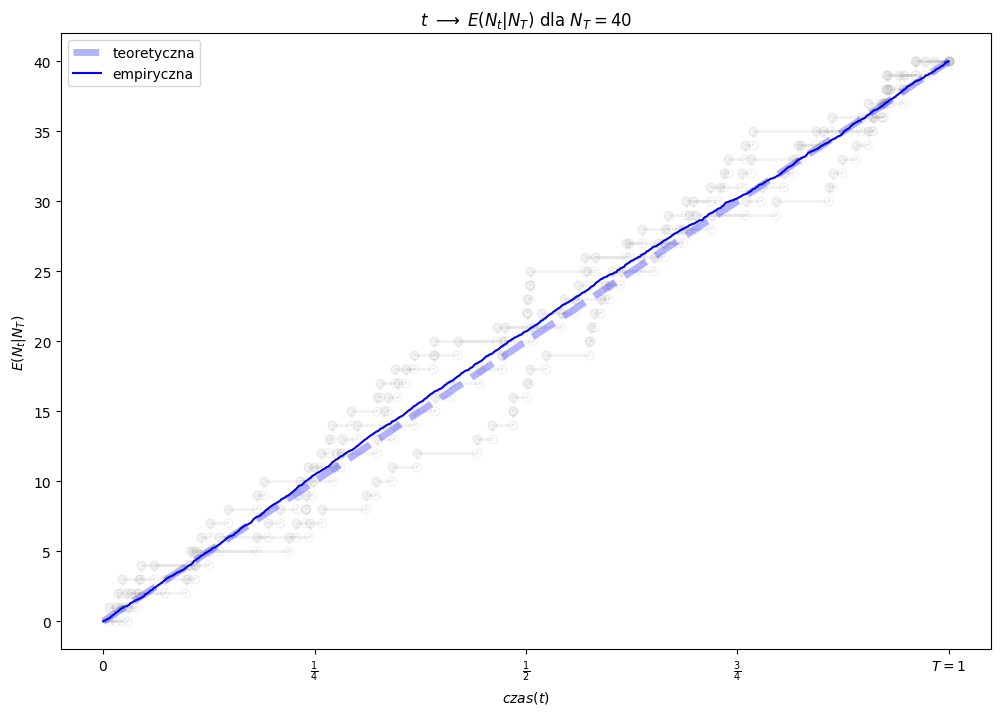

In [15]:
x_min, x_max = np.min(expected_values_x), np.max(expected_values_x)
x_range = np.linspace(x_min, x_max, time_steps_count)

plt.figure(figsize=(12, 8))

for i in range(4):
    plt_poisson_steps(get_poisson(T, N_T), T, alpha=0.1, c='gray')

plt.plot(x_range, (x_range * N_T) / T, '--', linewidth=5, c='blue', alpha=0.3, label="teoretyczna")
plt.plot(expected_values_x, expected_values_y, label="empiryczna", c='blue')

plt.title('$t$ $\\longrightarrow$ $E(N_t|N_T)$ dla $N_T = 40$')
plt.xlabel('$czas (t)$')
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['$0$', '$\\frac{1}{4}$', '$\\frac{1}{2}$', '$\\frac{3}{4}$', '$T = 1$'])
plt.ylabel('$E(N_t|N_T)$')

plt.legend()
plt.show()

Porównajmy rozwiązanie tego zadania dla paru różnych parametrów $N_T$.

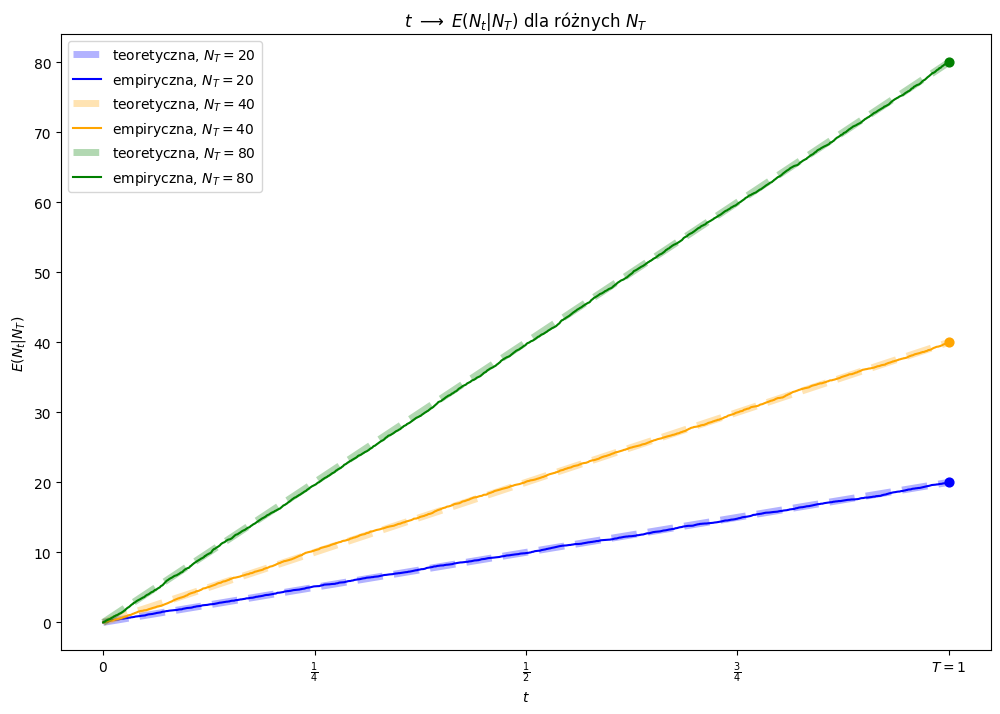

In [17]:
N_Ts = [20, 40, 80]
colors = ['blue', 'orange', 'green']
plt.figure(figsize=(12, 8))

for index, N_T in enumerate(N_Ts):
    clients_over_time_per_simulation = get_clients_over_time_per_simulation(T, N_T, monte_carlo_steps_count, time_range)
    expected_values_x, expected_values_y = get_clients_expected_values(clients_over_time_per_simulation, time_steps_count)

    x_min, x_max = np.min(expected_values_x), np.max(expected_values_x)
    x_range = np.linspace(x_min, x_max, time_steps_count)

    plt.plot(x_range, (x_range * N_T) / T, '--', linewidth=5, c=colors[index], alpha=0.3, label=f"teoretyczna, $N_T = {N_T}$")
    plt.plot(expected_values_x, expected_values_y, label=f"empiryczna, $N_T = {N_T}$", c=colors[index])
    plt.scatter([T], [N_T], c=colors[index], s=40)

plt.title('$t$ $\\longrightarrow$ $E(N_t|N_T)$ dla różnych $N_T$')
plt.xlabel('$t$')
plt.xticks([0, 0.25, 0.5, 0.75, 1], ['$0$', '$\\frac{1}{4}$', '$\\frac{1}{2}$', '$\\frac{3}{4}$', '$T = 1$'])
plt.ylabel('$E(N_t|N_T)$')

plt.legend()
plt.show()

### Ad c.


Zadanie na wstępie może wydawać się bardzo podobne, natomiast całkowicie zmienia się tutaj punkt realizacji. W poprzednim podpunkcie skupialiśmy się na tym, że znaliśmy liczbę klientów tylko w danej, aktualnej, chwili - teraz natomiast znamy całkowity ruch klientów w przeszłości - a nasze zadanie to wysumulowanie przyszłych zmian w tym ruchu  

Wynika z tego, że w tym zadaniu będziemy chcieli mieć możliwość generowania procesu Poissona nie tylko od punktu $(0, 0)$, zatem zajmijmy się rozwojem funkcji `get_poisson`

In [18]:
def get_poisson_extended(a, b, k):
    """
    Generuje proces Poissona o długości T na przedziale [a, b] dla danej liczby zdarzeń k.

    Parametry:
    - a: Początek przedziału, z którego losowane są czasy między zdarzeniami (włącznie).
    - b: Koniec przedziału, z którego losowane są czasy między zdarzeniami (włącznie).
    - k: Liczba zdarzeń w chwili T.

    Zwraca:
    - T_prime: Posortowana tablica zawierająca czasy między zdarzeniami dla procesu Poissona.
    """
    T_prime = np.random.uniform(a, b, k) * (b - a)
    T_prime = np.sort(T_prime)
    
    return T_prime

Następnie ustawmy podstawowe parametry oraz wygenerujmy zmianę klientów w przeszłości ($F_s$) - to jest nam znane.

In [19]:
T = 1
lambda_value = 10
monte_carlo_steps_count = 20
time_steps_count = 1_000
N_s = 20

F_s = get_poisson_extended(0, T, N_s)

Gdy posiadamy te dane możemy przystąpić do generowania procesów Poissona zmian klientów od chwili, w której się aktualnie znajdujemy uwzględniając znajomość przeszłości.

In [27]:
time_range = np.linspace(T, 2 * T, time_steps_count)

clients_over_time_per_simulation = {} # (time_step) key -> (value) value

for t in time_range:
    clients_over_time_per_simulation[t] = np.zeros(monte_carlo_steps_count)

expected_values_x = np.zeros(time_steps_count)
expected_values_y = np.zeros(time_steps_count)

for index in range(monte_carlo_steps_count):
    k = poisson.rvs(mu=lambda_value * T)
    N_t = get_poisson_extended(T, 2 * T, k)

    total_clients = N_s
    currently_checked_N_t = 0

    for t in time_range:
        while (
            currently_checked_N_t < len(N_t)
            and N_t[currently_checked_N_t] <= t
        ):
            total_clients += 1
            currently_checked_N_t += 1
        
        clients_over_time_per_simulation[t][index] = total_clients

W tym momencie wygenerowaliśmy sobie procesy dotyczące przyszłości - pozostaje obliczyć ich wartości oczekiwane, tak jak w podpunkcie <b>b.</b>

In [28]:
index = 0
for t, total_clients_count in clients_over_time_per_simulation.items():
    expected_values_x[index] = t
    expected_values_y[index] = total_clients_count.mean()

    index += 1

I wyświetlić je na wykresie!

In [29]:
x_min, x_max = np.min(expected_values_x), np.max(expected_values_x)
x_range = np.linspace(x_min, x_max, time_steps_count)

plt.figure(figsize=(12, 8))

for index in range(5):
    k = poisson.rvs(mu=lambda_value * T)
    N_t = get_poisson_extended(T, 2 * T, k)
    plt_poisson_steps(N_t, 2 * T, alpha=0.05, x0=T, y0=N_s)

plt.vlines(x=T, ymin=0 - 2, ymax=np.max(expected_values_y) + 1, linestyles='dashed', linewidth=2, color='black', alpha=0.3)
plt.text(T * 1.03, 2, f"$T = {T}$", color='black', fontsize=11, alpha=0.6)

plt.text(T * 0.35, np.max(expected_values_y) + 2, f"przeszłość", color='black', fontsize=11)
plt.text(T * 1.5, np.max(expected_values_y) + 2, f"przyszłość", color='black', fontsize=11)
plt.text(T * 0.97, np.max(expected_values_y) + 2, f"teraz", color='black', fontsize=11)

plt_poisson_steps(F_s, T)

# teo
plt.plot(time_range, N_s + lambda_value * (time_range - T), '--', linewidth=5, c='b', alpha=0.3, label="teoretyczna")
# empi
plt.plot(expected_values_x, expected_values_y, label=f"empiryczna", c='blue')

plt.title('$t$ $\\longrightarrow$ $E(N_t|F_s)$')
plt.xlabel('$t$')
plt.ylabel('$E(N_t|F_s)$')

plt.legend()
plt.show()

TypeError: 'int' object is not iterable

<Figure size 1200x800 with 0 Axes>

# Zadanie 5: Czas ruiny

## Treść zadania

Niech $X_t$ będzie procesem ruiny modelu Craméra-Lundberga
$$
X_t = u + ct - \sum ^{N_t}_{i=0}ξ_i
$$
gdzie $t,c,u ≥ 0$, $ξi ∼ Exp(η),$ $ξi ⊥ ξj$ dla $i \ne j$, E (ξi) = η, a $N_t$ jest procesem Poissona o intensywności λ. Czasem
ruiny klasycznej nazywamy zmienną $τ = inf\{t > 0|X_t < 0\}$. Prawdopodobieństwem ruiny w czasie nieskończonym
nazywamy funkcję $ψ(u,c) = P (τ < ∞)$. Wzór Pollaczka-Chinczyna mówi, że
$$
\psi(u,c) = \frac{\eta \lambda}{c}e^{-(\frac{1}{\eta} - \frac{\lambda}{c})u}.
$$
Zweryfikuj symulacyjnie ten wynik. W tym celu skorzystaj z pomocniczego prawdopodobieństwa ruiny w czasie skończonym $T$, tj. $Ψ(u,c,T) = P (τ < T)$, $T > 0$, dla odpowiednio dużego $T$. Sporządź wykresy funkcji $u → ψ(u,c_0)$ dla ustalonych $c_0$ oraz $c →ψ(u_0,c)$ dla ustalonych $u_0$ (kilka trajektorii na jednym wykresie) i porównaj je z wartościami wyestymowanymi. Powtórz analizę dla funkcji odwrotnej
$$
c(u,\psi) = \frac{\lambda u}{W_0(\frac{u \psi e^{\frac{u}{\eta}}}{\eta})},
$$
gdzie $W_0$ to gałąź funkcji $W$ Lamberta zdefiniowana poprzez równanie $W_0(xe^x) = x$ dla $x ≥0$ (scipy.special.lambertw).
Ta analiza odpowiada szukaniu wymaganej wartości wpłat przy danym kapitale początkowym w celu osiągnięcia
wymaganego prawdopodobieństwa ruiny. Zweryfikuj symulacyjnie ten wynik. Tym razem sporządź wykresy funkcji
$u →c(u,ψ_0)$ dla ustalonych $ψ_0$ (kilka trajektorii na jednym wykresie) i porównaj je z wartościami wyestymowanymi.
Pamiętaj, że gdy $c ≤λη$ to zachodzi $ψ = 1$!

<br>

## Rozwiązanie


## Czas ruiny
Badamy proces ruiny modelu Craméra-Lundberga oznaczonego wzorem:
$$
    X_t = u + ct − \sum _{i=0}^{N_t} ξ_i,
$$
gdzie 
- $u$ to kapitał początkowy
- $c$ to stała przyrostu
- $N_t$ to process Poissona o parametrze $\lambda$ wyznaczający czasu kolejnych szkód
- ξ to zmienna losowa o rozkładzie wykładniczym z parametrem $\eta$ wyznaczająca wielkość kosztów szkód

Będziemy chcieli zweryfikować wzór Pollaczka-Chinczyna na prawdopodobieństwo zajścia ruiny modelu  w czasie nieskończonym:
$$
ψ(u, c) =\frac{ηλ}{c} e^{−(\frac{1}{η} − \frac{\lambda}{c})u},
$$
W tym celu przeprowadzimy symulację modelu Craméra-Lundberga w pewnym skończonym czasie $T$. Następnie za pomocą metody Monte Carlo wyznaczymy prawdopodobieństwa zajścia ruiny przy pewnych parametrach. Te wyniki porównamy z wynikami wzoru Pollaczka-Chinczyna. Zdefiniujmy potrzebne funkcje:

In [56]:
def ruin(T = 10, n=10**3, u = 5, c = 2, lmbd=1, eta = 1):
    """
    Symuluje proces ruiny modelu Cramera-Lundberg'a z podanymi parametrami. Zwraca prawdopodobieństwo ruiny jako wartość z przedziału [0,1].
    """
    results = np.zeros(n)
    for i in range(n):
        k = np.random.poisson(lmbd*T)
        jumps = T * np.sort(np.random.uniform(0,1,k))
        claims = np.random.exponential(eta,k)
        sumclaims = np.cumsum(claims)
        R = u + c*jumps - sumclaims
        if sum(R<=0) > 0:
            results[i] = 1
        else:
            results[i] = 0
    return  sum(results)/n

def pol_chin(c = 2,u = 5,lmbd = 1,eta = 1):
    """
    Oblicza prawdopodobieństwo ruiny według wzoru Pollaczka-Chinczyna z określonymi warunkami początkowymi na nieskończonym
    przedziale czasowym. Zwraca prawdopodobieństwo ruiny jako wartość z przedziału [0,1].
    """
    return (1/(c)) * np.exp(-u*(1/eta - (lmbd/c)))

Aby sprawdzić wyniki otrzymane za pomocą wzoru Pollaczka-Chinczyka przeprowadzimy symulację procesu ruiny w czasie skończonym oraz naniesiemy na scatterplot otrzymane prawdopodobieństwa. Zdefiniujemy dwie funkcje wykonujące te działania odpowiednio dla stałych wartości $c$ oraz stałych wartości $u$.

In [35]:
def draw_const_c(T,n,u,c_0):
    """
    Oblicza prawdopodobieństwo ruiny psi za pomocą metody Monte Carlo, z danymi parametrami początkowymi
    oraz stałą wartością c. Rysuje wykres punktowy zależności psi od u.   
    """
    psi = np.zeros(len(u))
    for i in range(len(u)):
        psi[i] = ruin(T,n,u[i],c_0)
    plt.scatter(u,psi, marker=".")

def draw_const_u(T,n,u_0,c):
    """
    Oblicza prawdopodobieństwo ruiny psi za pomocą metody Monte Carlo, z danymi parametrami początkowymi
    oraz stałą wartością u. Rysuje wykres punktowy zależności psi od c.   
    """ 
    psi = np.zeros(len(c))
    for i in range(len(c)):
        psi[i] = ruin(T,n,u_0,c[i])
    plt.scatter(c,psi, marker=".")

W pierwszej kolejności zbadamy zachowanie się prawdopodobieństwa przy stałych wartościach przyrostu oraz różnych kapitałach początkowych. Wezmiemy $c=\{2,2.5,3\}$ oraz $u$ będące 100-elementowym wektorem liczb z przedziału $[1,10]$. Przy tych oraz przyszłych symulacjach horyzont czasowy będzie wynosił $T=10$, a parametrami rozkładów będą $\lambda = 1$ oraz $\eta = 1$

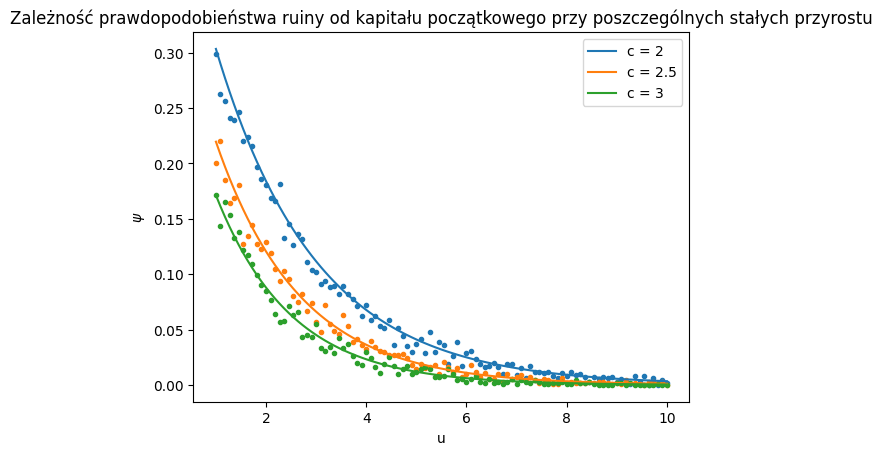

In [36]:
T=10
n=10**3
c_0 = 2
c_1 = 2.5
c_2 = 3

#obliczamy wartości pollaczka
u = np.linspace(1,10,100)
test1 = np.zeros(len(u))
test2 = np.zeros(len(u))
test3 = np.zeros(len(u))
for i in range(len(u)):
    test1[i] = pol_chin(c_0,u[i])
    test2[i] = pol_chin(c_1,u[i])
    test3[i] = pol_chin(c_2,u[i])

plot = plt.subplot()
plt.plot(u,test1, label="c = 2")
plt.plot(u,test2, label="c = 2.5")
plt.plot(u,test3, label="c = 3")

#obliczamy empirycznie
draw_const_c(T,n,u,c_0)
draw_const_c(T,n,u,c_1)
draw_const_c(T,n,u,c_2)
plot.set_xlabel("u")
plot.set_ylabel("$\psi$")
plt.title("Zależność prawdopodobieństwa ruiny od kapitału początkowego przy poszczególnych stałych przyrostu")
plt.legend()
plt.show()

Widać tutaj, że dla konkretnych wartości premii $c$, prawdopodobieństwo ruiny jest tym mniejsze im większy jest kapitał początkowy $u$.
Podobne zachowanie się prawdopodobieństwa zbadamy dla stałych kapitałów początkowych. Weźmiemu $u=\{4,6,8\}$ oraz $c$ będący 100-elementowych wektorem liczb z przedziału $[2,10]$.

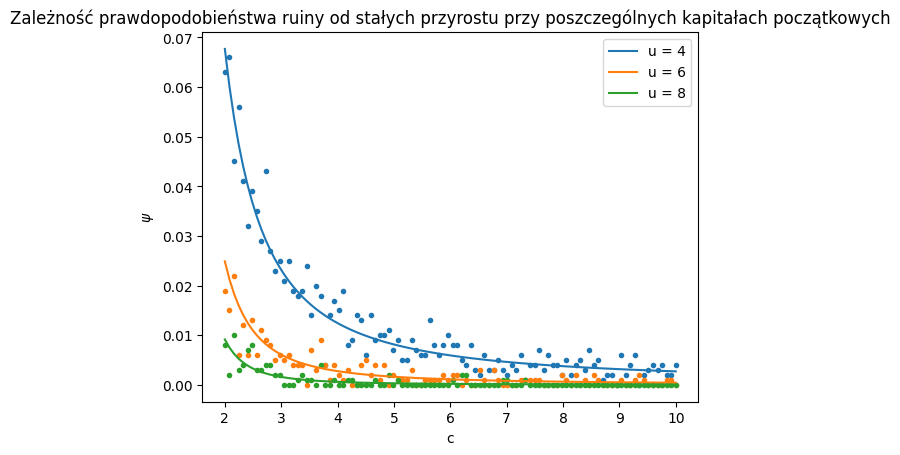

In [37]:
T=10
n=10**3
u_0 = 4
u_1 = 6
u_2 = 8

#obliczamy wartości pollaczka
c = np.linspace(2,10,100)
test1 = np.zeros(len(c))
test2 = np.zeros(len(c))
test3 = np.zeros(len(c))
for i in range(len(c)):
    test1[i] = pol_chin(c[i],u_0)
    test2[i] = pol_chin(c[i],u_1)
    test3[i] = pol_chin(c[i],u_2)

plot = plt.subplot()
plt.plot(c,test1, label="u = 4")
plt.plot(c,test2, label="u = 6")
plt.plot(c,test3, label="u = 8")

#obliczamy empirycznie
draw_const_u(T,n,u_0,c)
draw_const_u(T,n,u_1,c)
draw_const_u(T,n,u_2,c)
plot.set_xlabel("c")
plot.set_ylabel("$\psi$")
plt.title("Zależność prawdopodobieństwa ruiny od stałych przyrostu przy poszczególnych kapitałach początkowych")
plt.legend()
plt.show()

Można stąd łatwo zdobyć informacje jak dobrać $u$ i $c$ aby uzyskać dane prawdopodobieństwo ruiny.

Kolejnym krokiem naszej analizy będzie zastosowanie metod w celu wyznaczenia wartości $c$ przy danych kapitale początkowym i pradopodobieństwie ruiny. Wprowadzimy w tym celu funkcję odwrotną do wzoru Pollaczka-Chinczyna.

In [57]:
def invert_c(u,psi,lmbd = 1, eta=1):
    """
    Oblicza wartość c potrzebna do otrzymania prawdopodobieństwa psi przy danym kapitale początkowym u.
    """
    return np.real(lmbd*u/(lambertw(u*psi*np.exp(u/eta)/eta)))

Będziemy chcieli przetestować jej działanie. W tym celu za jej pomocą wyznaczymy wartości $c$ dla pewnego $u$ oraz konkretnych $\psi$, które potem wstawimy do wzoru Pollaczka-Chinczyna, aby sprawdzić czy dadzą początkowe prawdopodobieństwa.

In [62]:
#prezentacja działania funkcji odwrotnej

#obliczamy wartości c do osiągnięcia danego prawdop.
u=3
psi_1 = 0.1
psi_2 = 0.05
psi_3 = 0.025
print("Wartości prawdopodobieństwa od funkcji odwrotnej")
print("psi_1 = {}".format(psi_1))
print("psi_2 = {}".format(psi_2))
print("psi_3 = {}".format(psi_3))


c_result_1 = invert_c(u,psi_1)
c_result_2 = invert_c(u,psi_2)
c_result_3 = invert_c(u,psi_3)

print("Uzyskane wartości c")
print("c_1 = {}".format(c_result_1))
print("c_2 = {}".format(c_result_2))
print("c_3 = {}".format(c_result_3))

print("Wyniki wzoru Pollaczka-Chinczyna dla uzyskanych c")
print(pol_chin(c_result_1,3))
print(pol_chin(c_result_2,3))
print(pol_chin(c_result_3,3))

Wartości prawdopodobieństwa od funkcji odwrotnej
psi_1 = 0.1
psi_2 = 0.05
psi_3 = 0.025
Uzyskane wartości c
c_1 = 2.090710523553798
c_2 = 2.851451304221464
c_3 = 4.122818429760326
Wyniki wzoru Pollaczka-Chinczyna dla uzyskanych c
0.10000000000000002
0.04999999999999999
0.025


Jak widać otrzymaliśmy te same prawdopodobieństwa co na początku, co zapewnia nas o poprawnym działaniu funkcji. Następnie stworzymy funkcję która będzie wyliczała te same wartości $c$ empirycznie. Algorymt tego procesu jest bardzo złożony, dlatego wykorzystamy wiedzę o tym, że prawdopodobieństwo będzie malało im większe będzie $u$. Dlatego zaczniemy wykonywać symulację ruiny od większych do mniejszych $c$, aż prawdopodobieństwo symulacji nie będzie mniejsze od szukanego prawdopodobieństwa. Następnie zwiększamy $u$ i znowu sprawdzamy dla jakich kolejnych $c$ wartość prawdopodobieństwa ruiny będzie mniejsza od szukanej wartości.

In [63]:
def find_all_c(T,n,u_vector,c_test,psi,lmbd=1,eta=1):
    """
    Funckja obliczająca symulacyjnie wartości c potrzebne do osiągnięcia danego prawdopodobieństwa ruiny, dla danych wartości u. Funkcja zwraca
    tablicę wartości c.
    """
    u_index = 0 #odpowiada za indeks tablicy u jak i index obecnie szukanego c
    c_index = 0 #odpowiada za indeks obecnie sprawdzanej wartości c z tablicy c_test

    #szuka pierwszej wartości c zaczynając od największej z tablicy testowej
    c_found = np.zeros(len(u_vector))
    for i in range(1,len(c_test)+1):
        psi_test = ruin(T,n,u[u_index],c_test[-i],lmbd,eta)
        if psi_test > psi:
            c_found[u_index] = c_test[-i]
            u_index += 1
            break
    #tworzymy nowy wektor testowy dla c, który ma bardziej konkrenty zasięg
    c_test = np.flip(np.linspace(min(c_test),c_found[0],len(c_test))) 
    
    #szukamy kolejnych wartości c, zaczynając od największej z tablicy testowej
    while u_index < len(u_vector):
        psi_test = ruin(T,n,u[u_index],c_test[c_index],lmbd,eta)
        if psi_test > psi:
            c_found[u_index] = c_test[c_index]
            u_index += 1
        else:
            c_index += 1
            if c_index == len(c_test):
                break
    #po wyczerpaniu się indeksów tablicy testowej dla c, uzupełnia resztę miejsc ostatnią wartością c różną od zera
    for i in range(u_index,len(u_vector)):
        c_found[i] = c_found[u_index-1]

    return c_found

Porównamy teraz obydwie metody i zobaczymy czy dają zgodne wyniki. 

In [64]:
T = 10
u = np.linspace(2,10,100)
c_test = np.linspace(1.5,10,100)
n=10**3                     #dokładność liczenia prawdop. metodą monte carlo

c_1_empiric = find_all_c(T,n,u,c_test,psi_1)
c_2_empiric = find_all_c(T,n,u,c_test,psi_2)
c_3_empiric = find_all_c(T,n,u,c_test,psi_3)

c_1 = invert_c(u,psi_1) #wartości dla psi = 0.2
c_2 = invert_c(u,psi_2) #wartości dla psi = 0.1
c_3 = invert_c(u,psi_3) #wartości dla psi = 0.05

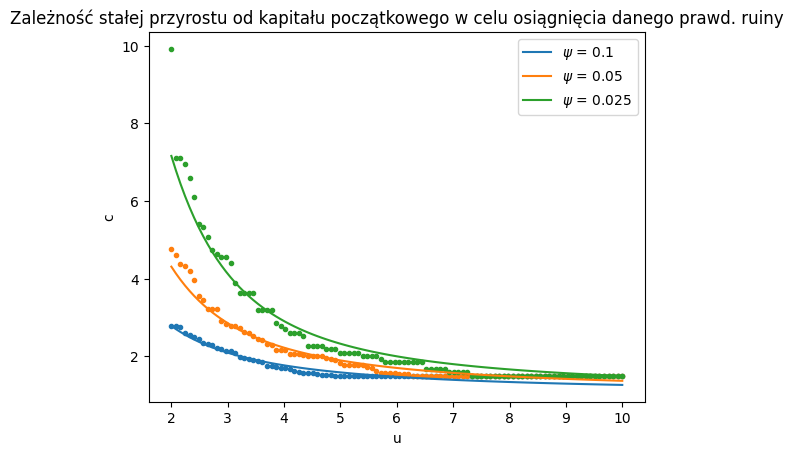

In [65]:
plot = plt.subplot()
plt.plot(u,c_1, label="$\psi$ = 0.1")
plt.scatter(u,c_1_empiric,marker=".")
plt.plot(u,c_2, label="$\psi$ = 0.05")
plt.scatter(u,c_2_empiric,marker=".")
plt.plot(u,c_3, label="$\psi$ = 0.025")
plt.scatter(u,c_3_empiric,marker=".")

plot.set_xlabel("u")
plot.set_ylabel("c")
plt.title("Zależność stałej przyrostu od kapitału początkowego w celu osiągnięcia danego prawd. ruiny")
plt.legend()
plt.show()

Na tym wykresie widać jak powinny być od siebie zależne $u$ oraz $c$, aby otrzymać oczekiwane prawdopodobieństwo ruiny. Dla przykładu, chcąc osiągnąć prawdopodobieństwo ruiny równe $\psi = 0.05$, należy ustalić kapitał początkowy $u = 2$ oraz stałą przyrostu $c = 6$, lub można także ustalić $u=6$ i $ c=2 $.

# Zadanie 6:

## Treść zadania

Ciągła zmienna losowa X ma rozkład arcusa sinusa (X ∼ Arcsine), gdy jej funkcja gęstości prawdopodobieństwa $p_X$ ma postać:

$$
p_X(x) = \frac{ 1 }{ \pi \sqrt{x(1 - x)} }\mathbb{1}_{(0, 1)}(x).
$$

Dystrybuanta tej zmiennej jest wtedy równa

$$
F_X(x) = 
\begin{cases}
0, \ \ \  x \lt 0, \\
\frac{2}{\pi}\arcsin(\sqrt{x}), \ \ \   x \in [0, 1], \\
1, \ \ \   x \gt 1.
\end{cases}
$$

Prawa arcusa sinusa dla procesu Wienera Wt brzmią następująco.

### Pierwsze prawo arcusa sinusa

$$
T_+ = \lambda ({ t \in [0, 1][W_t > 0] }) \sim \mathrm{Arcsine}
$$

gdzie $\lambda$ to miara Lebesgue’a. Oznacza to, że czas spędzony przez proces Wienera powyżej osi OX na odcinku [0,1] ma rozkład arcusa sinusa.

### Drugie prawo arcusa sinusa

$$
L = \sup{ \{ t \in [0, 1][W_t = 0] \} } \sim \mathrm{Arcsine}
$$

Inaczej mówiąc, ostatni moment uderzenia procesu Wienera na odcinku [0,1] w oś OX ma rozkład arcusa sinusa.

### Trzecie prawo arcusa sinusa

$$
W_M = \sup{ \{ W_t | t \in [0, 1] \} } \sim \mathrm{Arcsine}.
$$

Oznacza to, że moment osiągnięcia maksymalnej wartości przez proces Wienera na odcinku [0,1] ma rozkład arcusa sinusa.

<br>

Zweryfikuj symulacyjnie prawa arcusa sinusa dla procesu Wienera. W tym celu użyj porównania histogramów oraz dystrybuant empirycznych wysymulowanych próbek z teoretycznymi wartościami.

<br>

## Rozwiązanie


Ciągła zmienna losowa X ma rozkład arcusa sinusa (X ∼ Arcsine), gdy jej funkcja gęstości prawdopodobieństwa $p_X$ ma postać:

$$
p_X(x) = \frac{ 1 }{ \pi \sqrt{x(1 - x)} }\mathbb{1}_{(0, 1)}(x).
$$

Dystrybuanta tej zmiennej jest wtedy równa

$$
F_X(x) = 
\begin{cases}
0, \ \ \  x \lt 0, \\
\frac{2}{\pi}\arcsin(\sqrt{x}), \ \ \   x \in [0, 1], \\
1, \ \ \   x \gt 1.
\end{cases}
$$

Zaimplementujemy ten rozkład jako klasę:

In [42]:
class Arcsine:
    """
    Rozkład arcsine.
    @doc https://en.wikipedia.org/wiki/Arcsine_distribution
    """

    def pdf(self, x):
        """
        Funkcja gęstości prawdopodobieństwa w punkcie x.
        
        Parametry:
        - x: Wartości, dla których obliczana jest funkcja gęstości prawdopodobieństwa.

        Zwraca:
        - p_x: Wartości funkcji gęstości prawdopodobieństwa dla punktów x.
        """
        p_x = np.zeros_like(x)

        # correct indexes are position for x \in [0,1]
        correct_indexes = (x > 0) & (x < 1)

        root = np.sqrt(x[correct_indexes] * (1 - x[correct_indexes]))
        p_x[correct_indexes] = 1 / (np.pi * root)

        return p_x

    def cdf(self, x):
        """
        Funkcja dystrybuanty w punkcie x.
        
        Parametry:
        - x: Wartości, dla których obliczana jest funkcja dystrybuanty.

        Zwraca:
        - F_x: Wartości funkcji dystrybuanty dla punktów x.
        """
        F_x = np.zeros_like(x)
        F_x[x >= 1] = 1

        # correct indexes are position for x \in [0,1]
        correct_indexes = (x > 0) & (x < 1)

        x_root = np.sqrt(x[correct_indexes])
        F_x[correct_indexes] = (2 / np.pi) * np.arcsin(x_root)

        return F_x

arcsine = Arcsine()

### Proces Wieniera $W_t$

Kolejnym istotnym zagadnieniem dla realizacji tego zadania jest proces Wieniera $W_t$. Scharakteryzowany jest on przez następujące ważne dla nas <a href="https://en.wikipedia.org/wiki/Wiener_process">własności</a>:

- $W_0 = 0$,
- $W_{t + u} - W_t ~ N(0, \mu)$

Zgodnie z tymi założeniami zaimplementujmy go

In [43]:
def get_wiener_process(T, N):
    """
    Generuje trajektorię procesu Wienera.

    Parametry:
    - T: Czas trwania procesu.
    - N: Liczba kroków dyskretyzacji.

    Zwraca:
    - W: Tablica zawierająca trajektorię procesu Wienera.
    - t: Tablica zawierająca punkty czasowe odpowiadające trajektorii procesu Wienera.
    """
    dt = T / N
    t = np.linspace(0, T, N+1)

    dW = np.random.normal(0, np.sqrt(dt), N)
    W = np.zeros(N+1)
    
    W[1:] = np.cumsum(dW)
    
    return W, t

Posiadając takie przygotowanie możemy przejść do realizacji właściwej treści zadania, czyli weryfikacji trzech praw arcusa sinusa.

### Weryfikacja praw arcusa sinusa

#### Pierwsze prawo arcusa sinusa

$$
T_+ = \lambda ({ t \in [0, 1][W_t > 0] }) \sim \mathrm{Arcsine}
$$

gdzie $\lambda$ to miara Lebesgue’a. Oznacza to, że czas spędzony przez proces Wienera powyżej osi OX na odcinku [0,1] ma rozkład arcusa sinusa.

Rozpoczniemy od implementacji funkcji, która pozwoli nam wyliczyć $T_+$

In [44]:
def get_wiener_time_above_zero(W, t):
    """
    Oblicza czas, przez który proces Wienera przebywa nad poziomem zero.

    Parametry:
    - W: Trajektoria procesu Wienera.
    - t: Tablica zawierająca punkty czasowe odpowiadające trajektorii procesu Wienera.

    Zwraca:
    - czas nad poziomem zero: Czas, przez który proces Wienera przebywa nad poziomem zero.
    """

    W_above = W > 0
    dt = t[1] - t[0]

    return W_above.sum() * dt

Chcąc dokonać weryfikacji podanego prawa rozpoczniemy od określenia konfiguracji naszego zadania (te same parametry wykorzystamy również dla weryfikacji późniejszych praw).

In [45]:
T = 1
time_steps_count = 1_000
monte_carlo_steps_count = 10_000

Posiadając tak przygotowane zaplecze kodowe możemy z użyciem metody Monte Carlo sprawdzić pierwsze prawo arcusa sinusa.

In [46]:
T_plus = np.zeros(monte_carlo_steps_count)

for index in range(monte_carlo_steps_count):
    W, t = get_wiener_process(T, time_steps_count)
    T_plus[index] = get_wiener_time_above_zero(W, t)

Tak posiadane dane możemy porównać wygodnie na wykresie wraz z rozkładem arcusa sinusa

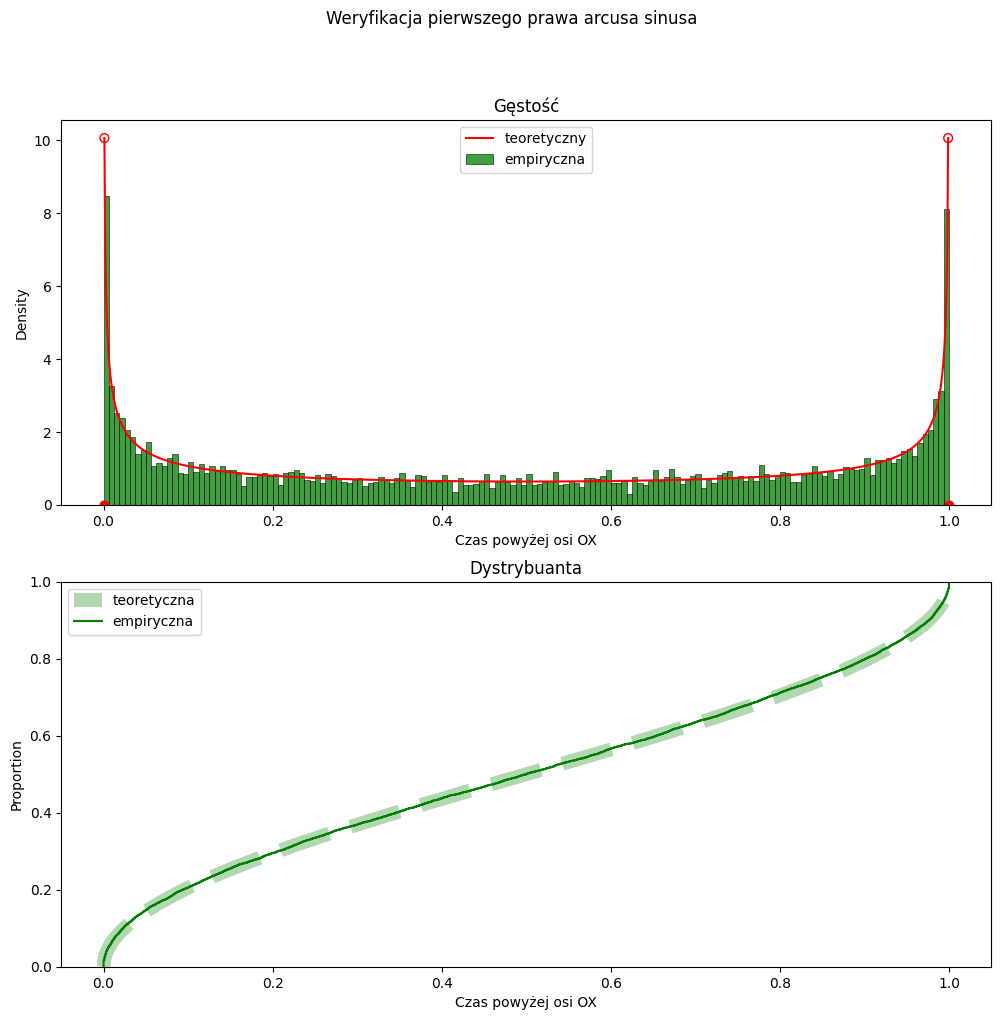

In [47]:
chart_x = np.linspace(np.min(T_plus), np.max(T_plus), time_steps_count)

plt.figure(figsize=(12, 11))

# Gęstość
plt.subplot(2, 1, 1)
plt.plot(chart_x[1:-1], arcsine.pdf(chart_x[1:-1]), 'r', label='teoretyczny')
sns.histplot(T_plus, stat="density", label="empiryczna", color='g', bins=160)
plt.scatter(x=[chart_x[1], chart_x[-2]], y=[arcsine.pdf(chart_x[1]), arcsine.pdf(chart_x[-2])], facecolors='none', edgecolors='r', s=40)
plt.scatter(x=[chart_x[0], chart_x[-1]], y=[arcsine.pdf(chart_x[0]), arcsine.pdf(chart_x[-1])], c='r', s=40)
plt.xlabel('Czas powyżej osi OX')
plt.title('Gęstość')
plt.legend()

# Dystrybuanta
plt.subplot(2, 1, 2)
plt.plot(chart_x, arcsine.cdf(chart_x), '--', linewidth=10, c='green', alpha=0.3, label="teoretyczna")
sns.ecdfplot(T_plus, label='empiryczna', c='green')
plt.xlabel('Czas powyżej osi OX')
plt.title('Dystrybuanta')
plt.legend()

plt.suptitle("Weryfikacja pierwszego prawa arcusa sinusa")

plt.show()

#### Drugie prawo arcusa sinusa

$$
L = \sup{ \{ t \in [0, 1][W_t = 0] \} } \sim \mathrm{Arcsine}
$$

Inaczej mówiąc, ostatni moment uderzenia procesu Wienera na odcinku [0,1] w oś OX ma rozkład arcusa sinusa.

Rozpoczniemy od implementacji funkcji, która pozwoli nam wyliczyć $L$

In [48]:
def last_time_process_hit(W, t):
    """
    Znajduje czas, w którym proces Wienera ostatnio przekroczył poziom zero.

    Parametry:
    - W: Trajektoria procesu Wienera.
    - t: Tablica zawierająca punkty czasowe odpowiadające trajektorii procesu Wienera.

    Zwraca:
    - last_hit_time: Czas, w którym proces Wienera ostatnio przekroczył poziom zero.
    """

    last_hist = 0

    sign = 1
    dt = t[1] - t[0]

    for index, W_i in enumerate(W):
        new_sign = 1 if W_i >= 0 else -1
        if new_sign != sign:
            last_hist = (index - 1) * dt + dt / 2
            sign = new_sign
    
    return last_hist

Ponieważ generowany przez nas proces Wieniera jest dyskretyzowany przez czas, zamiast sprawdzać czy nasza sprawdzana wartość $W_t = 0$, sprawdzamy czy wartości $W_t$ i $W_{t - 1}$ mają różne znaki. Jeśli tak to w symulacji procesu ciągłego Wieniera wiemy z twierdzenia Darboux, że odbył się moment uderzenia procesu Wieniera w oś OX. W tej implementacji zakładamy, że ten moment to $\frac{t_n + t_{n-1}}{2}$, natomiast przyjęty może zostać dowolny punkt $\in [t_{n - 1}, t_n]$ zgodnie z podanym twierdzeniem Darboux. Dla dostatecznie dużej dyskretyzacji czasu dobór punktu z tego przedziału nie pownien mieć znaczenia.

Posiadając tak przygotowane zaplecze kodowe możemy z użyciem metody Monte Carlo sprawdzić drugie prawo arcusa sinusa.

In [49]:
L = np.zeros(monte_carlo_steps_count)

for index in range(monte_carlo_steps_count):
    W, t = get_wiener_process(T, time_steps_count)
    L[index] = get_wiener_time_above_zero(W, t)

Tak posiadane dane możemy porównać wygodnie na wykresie wraz z rozkładem arcusa sinusa

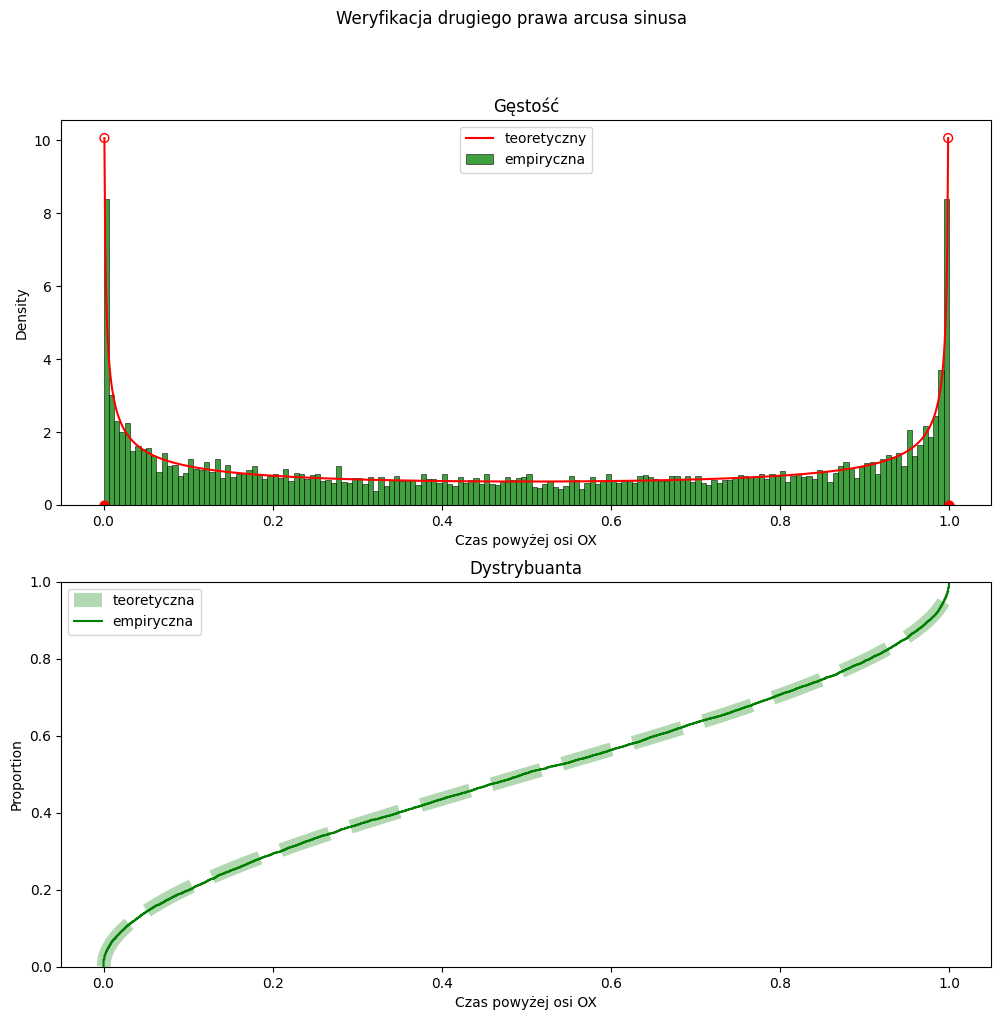

In [50]:
chart_x = np.linspace(np.min(L), np.max(L), time_steps_count)

plt.figure(figsize=(12, 11))

# Gęstość
plt.subplot(2, 1, 1)
plt.plot(chart_x[1:-1], arcsine.pdf(chart_x[1:-1]), 'r', label='teoretyczny')
sns.histplot(L, stat="density", label="empiryczna", color='g', bins=160)
plt.scatter(x=[chart_x[1], chart_x[-2]], y=[arcsine.pdf(chart_x[1]), arcsine.pdf(chart_x[-2])], facecolors='none', edgecolors='r', s=40)
plt.scatter(x=[chart_x[0], chart_x[-1]], y=[arcsine.pdf(chart_x[0]), arcsine.pdf(chart_x[-1])], c='r', s=40)
plt.xlabel('Czas powyżej osi OX')
plt.title('Gęstość')
plt.legend()

# Dystrybuanta
plt.subplot(2, 1, 2)
plt.plot(chart_x, arcsine.cdf(chart_x), '--', linewidth=10, c='green', alpha=0.3, label="teoretyczna")
sns.ecdfplot(L, label='empiryczna', c='green')
plt.xlabel('Czas powyżej osi OX')
plt.title('Dystrybuanta')
plt.legend()

plt.suptitle("Weryfikacja drugiego prawa arcusa sinusa")

plt.show()

#### Trzecie prawo arcusa sinusa

$$
W_M = \sup{ \{ W_t | t \in [0, 1] \} } \sim \mathrm{Arcsine}.
$$

Oznacza to, że moment osiągnięcia maksymalnej wartości przez proces Wienera na odcinku [0,1]
ma rozkład arcusa sinusa.

Rozpoczniemy od implementacji funkcji, która pozwoli nam wyliczyć $L$

In [51]:
def time_of_max_value(W, t):
    """
    Znajduje czas, w którym proces Wienera osiąga maksymalną wartość.

    Parametry:
    - W: Trajektoria procesu Wienera.
    - t: Tablica zawierająca punkty czasowe odpowiadające trajektorii procesu Wienera.

    Zwraca:
    - time_max_value: Czas, w którym proces Wienera osiąga maksymalną wartość.
    """

    return t[np.argmax(W)]

Używamy metody Monte Carlo

In [52]:
W_M = np.zeros(monte_carlo_steps_count)

for index in range(monte_carlo_steps_count):
    W, t = get_wiener_process(T, time_steps_count)
    W_M[index] = get_wiener_time_above_zero(W, t)

Tak posiadane dane możemy porównać wygodnie na wykresie wraz z rozkładem arcusa sinusa

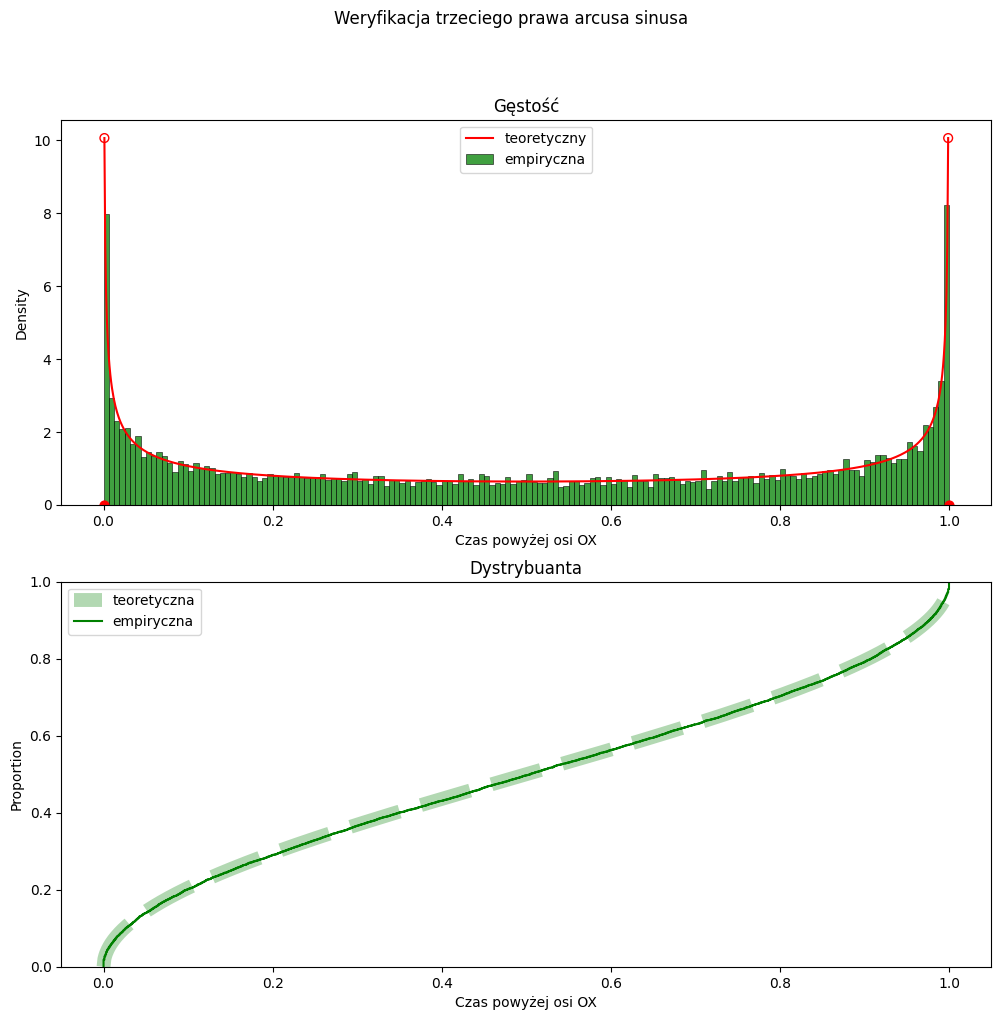

In [53]:
chart_x = np.linspace(np.min(W_M), np.max(W_M), time_steps_count)

plt.figure(figsize=(12, 11))

# Gęstość
plt.subplot(2, 1, 1)
plt.plot(chart_x[1:-1], arcsine.pdf(chart_x[1:-1]), 'r', label='teoretyczny')
sns.histplot(W_M, stat="density", label="empiryczna", color='g', bins=160)
plt.scatter(x=[chart_x[1], chart_x[-2]], y=[arcsine.pdf(chart_x[1]), arcsine.pdf(chart_x[-2])], facecolors='none', edgecolors='r', s=40)
plt.scatter(x=[chart_x[0], chart_x[-1]], y=[arcsine.pdf(chart_x[0]), arcsine.pdf(chart_x[-1])], c='r', s=40)
plt.xlabel('Czas powyżej osi OX')
plt.title('Gęstość')
plt.legend()

# Dystrybuanta
plt.subplot(2, 1, 2)
plt.plot(chart_x, arcsine.cdf(chart_x), '--', linewidth=10, c='green', alpha=0.3, label="teoretyczna")
sns.ecdfplot(W_M, label='empiryczna', c='green')
plt.xlabel('Czas powyżej osi OX')
plt.title('Dystrybuanta')
plt.legend()

plt.suptitle("Weryfikacja trzeciego prawa arcusa sinusa")

plt.show()